In [1]:
# 기본적인 라이브러리(기초세션에서 다룸)
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### font setting

In [3]:
import matplotlib.font_manager as fm

In [4]:
# 나눔 폰트 업로드
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 폰트가 정상적으로 설치됨.
sys_font = fm.findSystemFonts()
print("sys_font number : {}".format(len(sys_font)))

nanum_font = [f for f in sys_font if 'Nanum' in f]
print("nanum_font number : {}".format(len(nanum_font)))

Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 129496 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum.
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...
W: Operation was interrupted before it could finish
sys_font n

In [6]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴 알아보기
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능
        
current_font()

설정 폰트 글꼴: ['NanumSquare'], 설정 폰트 사이즈: 10.0


In [5]:
import matplotlib as mpl
path = '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf' # 원하는 폰트의 경로 가져오기
font_name = fm.FontProperties(fname = path, size = 10).get_name()
print(font_name)
plt.rc('font', family = font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False # 그래프의 x, y축에 정상적인 - 표시 설정

# 런타임 다시 시작!

NanumSquare


# 예제 1

사용할 데이터 : bike.csv

주어진 데이터는 서울시 공공데이터인 자전거 대여 수를 나타낸 데이터로 아래와 같다. 데이터에는 자전거 대여 수와 함께 ID, 시간, 날씨 등의 정보를 포함하고 있다.

서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터
즉, 따릉이 보관소별로 매일 자전거 대여

* id : 마포구에 있는 따릉이 보관소의 고유 id
* hour : 따릉이 보관소에서 기상상황을 측정한 시간
* temperature : 기온
* precipitation : 비가 오지 않았으면 0, 비가 오면 1, null은 비가 온 것도 아니고 안 온 것도 아니라서 센서가 확실히 측정불가한 상태
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존
* pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 측정한 날짜의 따릉이 대여 수

> 데이터 출처 : https://www.dacon.io/competitions/open/235576/data

## 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DSL/Session/[0131][HW]_LinearRegression_and_SVM/data/bike.csv'
bike = pd.read_csv(path)
bike.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431


## 어떤 Task인지 파악하기

데이터 구조 확인 및 어떤 task인지 파악을 한다.

In [ ]:
# (행,열)
# 행의 수 = 데이터(표본)의 갯수 = 1459
# 열의 수 = features들의 갯수 = 11

bike.shape

(1459, 11)

In [ ]:
# features 살펴보기

bike.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

(array([413., 237., 327., 188., 120.,  83.,  47.,  33.,   6.,   5.]),
 array([  1.,  44.,  87., 130., 173., 216., 259., 302., 345., 388., 431.]),
 <a list of 10 Patch objects>)

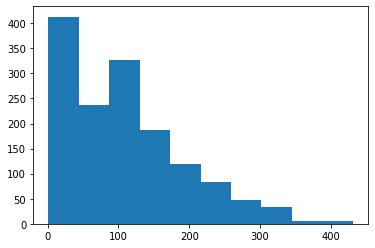

In [ ]:
# y값 = 'count(자전거 대여 대수)'열

# y(label)값 뜯어내기
y_label = bike.loc[:,'count']

# y값 분포 확인
y_label.value_counts()
plt.hist(y_label.values)

# 결론
# y값 = exist -> Supervised
# y값 = 연속형 -> regression

In [ ]:
# 위의 y값을 제외한 진정한 X값들로 이루어진 features 만들기

X_features = bike.drop(['count'], axis=1)
X_features.columns # 10개의 열들이 진정한 X_features로 사용

# 즉, 10개의 X_features열들로 1개의 y_label인 'count'를 맞추는 문제
# 여기서 행은 데이터의 갯수, 즉 이러한 갯수의 데이터를 이용해 학습을 시킨다는 의미

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'],
      dtype='object')

In [ ]:
# X_features 열들이 ['연속형','범주형']인지 확인

# 1~5번째 행(데이터)
X_features.head()

# 범주형 데이터 : 'hour_bef_precipitation'
# 연속형 데이터 : 나머지

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0


* 지금까지 배운 모델 중 회귀문제를 풀 수 있는 모델은 '선형회귀'이다.

> * 선형회귀의 경우, X값 중에 범주형 데이터가 있을 경우에
> * label_encoding -> one-hot_encoding으로 바꾸어주어야한다.

> * 범주형 데이터 : 'hour_bef_precipitation'
> * 연속형 데이터 : 나머지

* 주의
> * 사실 hour의 경우에 0~23까지가 대략 60개씩 나타난다.
> * 따라서 hour를 어떻게 생각하느냐에 따라 범주형인지 연속형인지가 결정된다.
> * 실제로는 데이터를 측정을 하는 과정에서 확실하게 알 수 있지만, 지금의 경우에는 있는 데이터로 주어진 정보로 분석을 함으로 어떤 방식으로 데이터가 수집되었는지 생각해보아야한다.

* 예시
> * ex. hour=23일 경우, 23시에 기상상황을 측정했다는 의미 -> 범주형자료
> * ex. hour=23일 경우, 0~23시부터 기상상황을 측정하여 평균을 했다는 의미 -> 연속형자료
> * 앞으로의 문제의 경우에 hour을 범주형으로 해석할 경우, 24개의 집단에 대한 one-hot encoding을 진행해야함으로 변수의 수를 1개 -> 24개로 바꾸지 않기 위해 그냥 연속형으로 생각해 간단하게 하기로 한다.
> * 궁금하신 분들은 'hour'을 one-hot_encoding을 하여 진행해보세요.



In [ ]:
bike.hour.value_counts()

20    61
4     61
5     61
11    61
22    61
19    61
15    61
7     61
8     61
10    61
1     61
14    61
9     61
3     61
2     61
18    61
23    61
6     61
12    61
13    60
17    60
16    60
0     60
21    60
Name: hour, dtype: int64

In [ ]:
# 범주형 데이터(hour_bef_precipitation) 살펴보기

bike.loc[:,'hour_bef_precipitation'].value_counts()

# 해당 데이터의 경우, '0 or 1'인 binary-class를 갖는다.

0.0    1404
1.0      46
Name: hour_bef_precipitation, dtype: int64

## 데이터 전처리하기(1)
* 결측치 파악

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

데이터 전처리의 경우, 개인의 논리와 그간의 데이터 분석경험에 따라 어느 정도 바뀌어질 수 있다. 따라서 이번 시간에 제시된 방법이 정답은 아니고, 하나의 방법으로 제시하는 측면이라는 걸 확인해주길 바랍니다.

### 결측치 처리

In [ ]:
# 항상 결측치가 있는지 확인이 필요하다.

bike.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      9
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

질문 : 결측치를 어떻게 처리할 것인가?

범주형 축(hour_bef_precipitation)의 경우,

여러가지 방법이 있다. 이번시간에서는 그 중에서 한 번 생각해볼 2가지 방법을 제안한다.

1. 새로운 class를 만들지 않고 기존의 class에 넣을 수 있다.
> 설명 : 해당 축은 '0 or 1'값을 갖는 범주형 feature이다. 따라서 '0 or 1'값이 아닌 새로운 class를 만들지 않고, 기존의 '0 or 1'값으로 null을 채운다. 이 때, 최빈값을 사용하기로 한다. 단, '0 or 1'이 같은 비율로 존재할 경우를 주의하여 이 상황에는 어떻게 할지 고민해볼 것

2. 새로운 class를 만들어, 기존의 class 범주를 확장시켜 null값을 채운다.
> 설명 : null값을 하나의 class로 보고 이 값들만 들어가는 새로운 범주를 만든다. 예를 들면, '0 or 1'이 있기에 같은 정수형 범주인 '2'로 null값을 바꿔주면 된다.

이번 시간에서는 2번 방법을 사용한다.

In [ ]:
# 이번시간에 범주형 축(hour_bef_precipitation)의 경우, "null -> 새로운 범주 클래스(2)로 만들기"를 사용

# null값을 찾아내기 위해 'null!=null'인 사실을 이용한다.
x = np.nan
x==x

False

In [ ]:
# 위의 null값의 특징과 apply()함수를 이용

bike.loc[:,'hour_bef_precipitation'] = bike.loc[:,'hour_bef_precipitation'].apply(lambda x:2 if x!=x else x)

bike.loc[:,'hour_bef_precipitation'].value_counts() # 2라는 class가 새로 생겨남

0.0    1404
1.0      46
2.0       9
Name: hour_bef_precipitation, dtype: int64

In [ ]:
# 'hour_bef_precipitation'의 null값 2개가 2로 바뀜으로써, 해당 열의 null값이 0이 됨

bike.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      0
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

나머지의 연속형 축들의 경우,

null값의 갯수에 따라 다음과 같이 결측치를 처리

1. null값 10개 미만 : 최빈값으로 대체 (빈도가 같아 최빈값이 2개 이상이면, 구한 최빈값의 평균으로 처리)
2. null값 10개 이상 100개 미만 : 평균값으로 대체
3. null값 100개 이상 : null값 행 제거 

#### 1. null값 10개 미만 : 최빈값으로 대체 (빈도가 같아 최빈값이 2개 이상이면, 구한 최빈값의 평균으로 처리)

In [ ]:
# null값이 10개 미만인 축 선별
# (hour_bef_temperature, hour_bef_windspeed, hour_bef_humidity, hour_bef_visibility)

# 각 features축별 최빈값 확인
lessthan10_list = ['hour_bef_temperature', 'hour_bef_windspeed',
                   'hour_bef_humidity', 'hour_bef_visibility']

bike.loc[:,lessthan10_list].mode()

# 'hour_bef_temperature'축이 최빈값이 2개이다.

,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility
0,18.8,2.0,44.0,2000.0
1,19.4,NaN,NaN,NaN


In [ ]:
# 최빈값이 2개인 것들을 처리하기 위해, mode()로 나온 값에 평균을 해준다.

bike.loc[:,lessthan10_list].mode().mean()

hour_bef_temperature      19.1
hour_bef_windspeed         2.0
hour_bef_humidity         44.0
hour_bef_visibility     2000.0
dtype: float64

In [ ]:
# null값을 최빈값으로 채워준다.
for name in lessthan10_list:
    bike[name].fillna(bike[name].mode().mean(), inplace=True)

# 변경된 결과를 확인
bike.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

#### 2. null값 10개 이상 100개 미만 : 평균값으로 대체


In [ ]:
# null값이 10개 이상 100개 미만인 축 선별
# (hour_bef_ozone, hour_bef_pm10)

lessthan100_list = ['hour_bef_ozone', 'hour_bef_pm10']
bike.loc[:,lessthan100_list].mean()

# null값을 평균값으로 채워준다.
for name in lessthan100_list:
    bike[name].fillna(bike[name].mean(), inplace=True)

# 변경된 결과를 확인
bike.isnull().sum()    

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone              0
hour_bef_pm10               0
hour_bef_pm2.5            117
count                       0
dtype: int64

#### 3. null값 100개 이상 : null값 행 제거 


In [ ]:
# null값이 100개 이상인 축 선별
# hour_bef_pm2.5

# null값을 가진 행(데이터)을 제거해준다.
bike.dropna(subset = ['hour_bef_pm2.5'], inplace=True)

# 변경된 결과를 확인
bike.isnull().sum()  

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [ ]:
# 결측치를 가진 행(데이터)을 일부 삭제하였음으로, 일부 index는 없을 것이다.
# 따라서 결측치를 모두 처리한 데이터의 index를 정리해줌.

bike.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458],
           dtype='int64', length=1342)

In [ ]:
# index 정리

bike.reset_index(drop=True, inplace=True) # drop : index열을 만들것인지 여부
bike.index

RangeIndex(start=0, stop=1342, step=1)

## 데이터 전처리하기(2)
* 범주형 X 데이터 처리 및 변수제거

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

### 1. 범주형 X데이터 처리

* 'hour_bef_precipitation'열의 경우, 범주형이나 [0,1,2]형태로 label_encoding이 되어있다.
* 따라서 one-hot_encoding을 해주어야 앞으로의 계산이 올바르다.

> 참고
> * label_encoding : '냉장고','맥주' -> '1','2'
> * one-hot_encoding : '냉장고','맥주' -> [1,0],[0,1]
> * 자료 : https://hye-z.tistory.com/m/16#:~:text=One%2DHot%20Encoding,-One%2DHot%20Encoding&text=%EC%9D%B4%ED%9B%84%20%EA%B0%9C%EB%B3%84%EB%A1%9C%20%ED%95%B4%EB%8B%B9%20%EC%BB%AC%EB%9F%BC,%EB%B3%80%ED%99%98%20%ED%9B%84%20%EC%82%AC%EC%9A%A9%EA%B0%80%EB%8A%A5%ED%95%98%EB%8B%A4.

> 특히, 선형회귀에서는 범주형변수를 dummy-variable로 하여 처리한다.
> * https://drive.google.com/drive/folders/14vLj8wME6-_RsRULfHDH0ZFvdsnTs9E3?usp=share_link

In [ ]:
# label_encoding된 'hour_bef_precipitation'열

bike.loc[:,'hour_bef_precipitation']

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1337    0.0
1338    0.0
1339    0.0
1340    0.0
1341    0.0
Name: hour_bef_precipitation, Length: 1342, dtype: float64

In [ ]:
# one-hot_encoding된 'hour_bef_precipitation'열

temp = pd.get_dummies(bike.loc[:,'hour_bef_precipitation'])
temp.columns = ['hbp1','hbp2','hbp3']
temp

,hbp1,hbp2,hbp3
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
1337,1,0,0
1338,1,0,0
1339,1,0,0
1340,1,0,0


In [ ]:
# 새로 encoding한 데이터로 바꿔주기

bike = bike.drop(['hour_bef_precipitation'], axis=1)
bike = pd.concat([bike, temp], axis=1)
bike.head()

,id,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hbp1,hbp2,hbp3
0,3,20,16.3,1.5,89.0,576.0,0.027,76.0,33.0,49,0,1,0
1,6,13,20.1,1.4,48.0,916.0,0.042,73.0,40.0,159,1,0,0
2,7,6,13.9,0.7,79.0,1382.0,0.033,32.0,19.0,26,1,0,0
3,8,23,8.1,2.7,54.0,946.0,0.040,75.0,64.0,57,1,0,0
4,9,18,29.5,4.8,7.0,2000.0,0.057,27.0,11.0,431,1,0,0


In [ ]:
# 변경된 'y_label', 'X_features' 만들기

y_label = bike.loc[:,'count']
X_features = bike.drop(['count'], axis=1)

### 2-0. 의미없는 변수제거

In [ ]:
# 그 자체로 의미없는 열 제거

# id열 삭제

X_features = X_features.drop(['id'], axis=1)
X_features.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone',
       'hour_bef_pm10', 'hour_bef_pm2.5', 'hbp1', 'hbp2', 'hbp3'],
      dtype='object')

### 2-1. 다중공선성으로 변수 제거

다중공선성이 있는 X변수를 제거한다.


여러가지 회귀 모델 중 선형회귀모형을 사용하도록 한다. 선형회귀모형을 사용할 때, 다중공선성을 통해 X_features들을 골라낼 수 있다.

#### 2-1-1. 상관계수를 살펴본다.(상관행렬 이용)
* 변수 제거 후에는 X2_features로 새로 지정

1. X_features들의 서로 다른 축들 중에 서로의 상관관계가 높은 것을 찾는다.
* 상관관계가 높은 두 축은 다른 축으로 설명이 가능하다는 뜻임으로, 두 개를 모두 이용하지 않고 1개만 사용하자.

2. 서로 상관관계가 높은 것들 중 y_label과의 상관관계가 높은 것을 남겨두고, 낮은 것을 제거한다.
* 즉, 서로가 서로를 설명할 수 있는 X_features내의 두 축에 대하여 어떤 것을 남길지에 대한 기준을 정해야한다. 이 때, y값과의 상관계수값이 더 큰 것을 남기도록 한다.
* 향후, 배울 차원축소에서 '변수선택'의 한 기법(mRMR)에서 비슷하게 적용된다.

새로운 X_features를 X2_features라 하자.

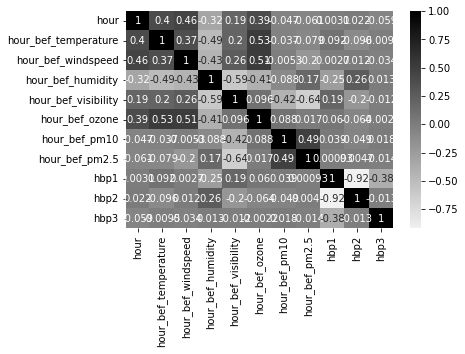

In [ ]:
# 1. X_features들의 서로 다른 축들 중에 서로의 상관관계가 높은 것을 찾는다.
# sns라이브러리를 통해 시각적으로 확인
# 색깔이 진할수록 상관관계가 높다.

cmap = sns.light_palette(color="black", as_cmap=True)
sns.heatmap(X_features.corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
# pandas내부의 corr()함수를 통해 수치적으로 정확히 확인

cor_matrix = abs(X_features.corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hbp1,hbp2,hbp3
hour,0.000000,0.402386,0.459823,0.324711,0.193399,0.386720,0.047382,0.061229,0.003116,0.021609,0.058964
hour_bef_temperature,0.402386,0.000000,0.370793,0.486215,0.200341,0.525443,0.037487,0.078665,0.092274,0.095737,0.009481
hour_bef_windspeed,0.459823,0.370793,0.000000,0.427852,0.261902,0.512580,0.005339,0.198391,0.002724,0.011543,0.034203
hour_bef_humidity,0.324711,0.486215,0.427852,0.000000,0.594545,0.405196,0.088137,0.167736,0.249698,0.264583,0.012641
hour_bef_visibility,0.193399,0.200341,0.261902,0.594545,0.000000,0.096312,0.419691,0.644989,0.186625,0.196813,0.011659
hour_bef_ozone,0.386720,0.525443,0.512580,0.405196,0.096312,0.000000,0.088233,0.017284,0.060359,0.064331,0.002173
hour_bef_pm10,0.047382,0.037487,0.005339,0.088137,0.419691,0.088233,0.000000,0.489191,0.038516,0.049464,0.018476
hour_bef_pm2.5,0.061229,0.078665,0.198391,0.167736,0.644989,0.017284,0.489191,0.000000,0.000930,0.004742,0.013567
hbp1,0.003116,0.092274,0.002724,0.249698,0.186625,0.060359,0.038516,0.000930,0.000000,0.920048,0.380097
hbp2,0.021609,0.095737,0.011543,0.264583,0.196813,0.064331,0.049464,0.004742,0.920048,0.000000,0.012692


In [ ]:
# 상관계수값이 높은 순대로 정렬

np.sort(cor_matrix.values.flatten())[::-1]

# corr(a,b) = corr(b,a)임으로 똑같은 값이 2개씩 나온다.

array([0.92004794, 0.92004794, 0.64498948, 0.64498948, 0.59454503,
       0.59454503, 0.5254433 , 0.5254433 , 0.51258025, 0.51258025,
       0.48919082, 0.48919082, 0.48621461, 0.48621461, 0.45982254,
       0.45982254, 0.42785228, 0.42785228, 0.4196908 , 0.4196908 ,
       0.40519649, 0.40519649, 0.40238566, 0.40238566, 0.38672037,
       0.38672037, 0.38009691, 0.38009691, 0.37079319, 0.37079319,
       0.32471089, 0.32471089, 0.26458267, 0.26458267, 0.26190158,
       0.26190158, 0.24969783, 0.24969783, 0.20034088, 0.20034088,
       0.19839124, 0.19839124, 0.19681324, 0.19681324, 0.1933993 ,
       0.1933993 , 0.18662483, 0.18662483, 0.16773596, 0.16773596,
       0.09631191, 0.09631191, 0.09573713, 0.09573713, 0.09227373,
       0.09227373, 0.08823347, 0.08823347, 0.08813721, 0.08813721,
       0.07866529, 0.07866529, 0.064331  , 0.064331  , 0.06122932,
       0.06122932, 0.06035891, 0.06035891, 0.05896394, 0.05896394,
       0.04946419, 0.04946419, 0.0473816 , 0.0473816 , 0.03851

In [ ]:
# 상관관수값이 가장 큰 두 축을 찾기

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : hbp1 & hbp2


여기서 확인해볼 점은 hbp1과 hbp2는 같은 범주형 축인 'hour_bef_precipitation'에서 나온 새 축이라는 것이다. 

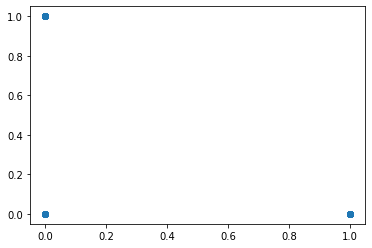

In [ ]:
# 실제 산점도를 그려보아도, 이 축들의 상관관계가 높은 것이 의미가 없음을 확인할 수 있다.

plt.scatter(bike.hbp1,bike.hbp2)

In [ ]:
# one-hot encoding과정에서 생긴 hbp1~hbp3는 제외하고 다시 진행

cor_matrix = abs(X_features.iloc[:,:-3].corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
hour,0.000000,0.402386,0.459823,0.324711,0.193399,0.386720,0.047382,0.061229
hour_bef_temperature,0.402386,0.000000,0.370793,0.486215,0.200341,0.525443,0.037487,0.078665
hour_bef_windspeed,0.459823,0.370793,0.000000,0.427852,0.261902,0.512580,0.005339,0.198391
hour_bef_humidity,0.324711,0.486215,0.427852,0.000000,0.594545,0.405196,0.088137,0.167736
hour_bef_visibility,0.193399,0.200341,0.261902,0.594545,0.000000,0.096312,0.419691,0.644989
hour_bef_ozone,0.386720,0.525443,0.512580,0.405196,0.096312,0.000000,0.088233,0.017284
hour_bef_pm10,0.047382,0.037487,0.005339,0.088137,0.419691,0.088233,0.000000,0.489191
hour_bef_pm2.5,0.061229,0.078665,0.198391,0.167736,0.644989,0.017284,0.489191,0.000000


In [ ]:
# 상관계수값이 높은 순대로 정렬

np.sort(cor_matrix.values.flatten())[::-1]

# corr(a,b) = corr(b,a)임으로 똑같은 값이 2개씩 나온다.
# 가장 큰 값이 '0.64498948'정도이다.
# 이 값을 가진 두 축을 찾아 하나를 제거하도록 하자.

# 참고
# 사실 어떤 것을 제거할지는 개인의 판단에 맡긴다.
# 상관관계가 높은 두 축들을 찾아내어, 두 축에 대한 2차원 산점도를 그려보고 결정해도 된다.
# 왜냐하면, corr는 하나의 지표임으로 두 축과의 관계를 잘 나타내지 않을 수 있기 때문.

array([0.64498948, 0.64498948, 0.59454503, 0.59454503, 0.5254433 ,
       0.5254433 , 0.51258025, 0.51258025, 0.48919082, 0.48919082,
       0.48621461, 0.48621461, 0.45982254, 0.45982254, 0.42785228,
       0.42785228, 0.4196908 , 0.4196908 , 0.40519649, 0.40519649,
       0.40238566, 0.40238566, 0.38672037, 0.38672037, 0.37079319,
       0.37079319, 0.32471089, 0.32471089, 0.26190158, 0.26190158,
       0.20034088, 0.20034088, 0.19839124, 0.19839124, 0.1933993 ,
       0.1933993 , 0.16773596, 0.16773596, 0.09631191, 0.09631191,
       0.08823347, 0.08823347, 0.08813721, 0.08813721, 0.07866529,
       0.07866529, 0.06122932, 0.06122932, 0.0473816 , 0.0473816 ,
       0.03748724, 0.03748724, 0.01728425, 0.01728425, 0.00533882,
       0.00533882, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [ ]:
# 상관관수값이 가장 큰 두 축을 찾기

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : hour_bef_visibility & hour_bef_pm2.5


In [ ]:
# 2. 서로 상관관계가 높은 것들 중 y_label과의 상관관계가 높은 것을 남겨두고, 낮은 것을 제거한다. 

# 'hour_bef_visibility' & 'hour_bef_pm2.5'

print('hour_bef_visibility :', X_features.loc[:,'hour_bef_visibility'].corr(y_label))
print('hour_bef_pm2.5 :', X_features.loc[:,'hour_bef_pm2.5'].corr(y_label))

hour_bef_visibility : 0.30660493443433273
hour_bef_pm2.5 : -0.13429258191572585


In [ ]:
# y_target과 상관계수값이 더 작은 'hour_bef_pm2.5'열을 제거한다.

X2_features = X_features.drop('hour_bef_pm2.5', axis=1)
X2_features.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone',
       'hour_bef_pm10', 'hbp1', 'hbp2', 'hbp3'],
      dtype='object')

#### 2-1-2. VIF를 통해 다중공선성 위험이 제일 큰 변수 한개를 제거
* 위에서 변수를 제거한 이후 만들어진 X2_features을 사용한다.
* 변수 제거 후에는 X3_features로 새로 지정


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 값을 저장할 데이터프레임 변수
vif = pd.DataFrame()

# 첫번째 features축은 columns이름으로
vif["features"] = X2_features.columns # 독립변수들의 이름들로 구성된 features열 추가

# 두번째 축은 VIF값을 계산하여 집어넣기
vif["VIF Factor"] = [variance_inflation_factor(X2_features.values, i) for i in range(X2_features.shape[1])] # 리스트내포

vif

,features,VIF Factor
0,hour,1.408332
1,hour_bef_temperature,1.706727
2,hour_bef_windspeed,1.643662
3,hour_bef_humidity,2.869818
4,hour_bef_visibility,2.567377
5,hour_bef_ozone,1.740091
6,hour_bef_pm10,1.624140
7,hbp1,125.665213
8,hbp2,5.122999
9,hbp3,1.688444


VIF란?
* 어떤 축이 다른 축으로 표현될 수 있느냐를 R^2으로 나타낸 점수이다.
* hbp1~hbp3의 경우, hp3는 9개의 1과 나머지는 모두 0으로 되어 있다.
* 따라서 hbp1과 hbp2 둘 중 하나는 1임으로 'hbp1+hbp2=1' 관계라고 볼 수 있다.
* 즉, hbp1 = 1-hbp2 로 표현될 수 있고, 이는 hbp1이 hbp2로 표현될 수 있다는 것을 의미한다.
* 따라서 hbp1이 제거되어야한다.

In [ ]:
X2_features.hbp1 == 1-X2_features.hbp2

0       True
1       True
2       True
3       True
4       True
        ... 
1337    True
1338    True
1339    True
1340    True
1341    True
Length: 1342, dtype: bool

In [ ]:
# 다중공선성의 제거를 위해 VIF값이 가장 큰 'hbp1'열을 제거
# VIF가 크다는 것은 그 열이 다른 열들로 표현이 잘 된다는 것을 의미한다.
# VIF값이 10을 넘으면, 제거를 하는 것이 좋다.

X3_features = X2_features.drop('hbp1', axis=1)
X3_features.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone',
       'hour_bef_pm10', 'hbp2', 'hbp3'],
      dtype='object')

### 2-2. 통계적 검정으로 변수 제거
t-test를 통해 통계적으로 회귀계수가 0이라고 판단된 X변수를 제거한다.
> 참고로, t-test를 하기 위해서는 모델학습이 우선시되어야한다. 따라서 사실상 통계적 검정으로 변수를 제거하는 방법은 학습데이터로 모델학습을 한 뒤에 하는게 맞으나, 변수제거에서 한꺼번에 다루기 위해 여기서 다루었다.

상관계수행렬, VIF를 통해 다중공선성이 제거된 데이터(X3_features)로 statsmodel을 통해 summary 출력
* t-test로 0이라고 판단된 변수를 제거한 X4_features로 새로 지정

In [ ]:
# Linear Regression모델 적용 시, 통계적 정보를 주는 라이브러리(기초세션의 통계적사고에서 다룸)
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 상수항을 추가한 다중선형회귀
# 기초세션의 '통계적사고'에서 다룬 선형회귀 내용을 가져와 사용

X_constant = sm.add_constant(X3_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     214.3
Date:                Mon, 06 Feb 2023   Prob (F-statistic):          1.28e-251
Time:                        01:29:57   Log-Likelihood:                -7233.5
No. Observations:                1342   AIC:                         1.449e+04
Df Residuals:                    1332   BIC:                         1.454e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -25.0253     16.586     -1.509      0.132     -57.563       7.512
hour                     4.8544      0.256     18.976      0.000       4.353       5.356
hour_bef_temperature     5.2348      0.366     14.318      0.000       4.518       5.952
hour_bef_windspeed       4.9724      1.351      3.680      0.000       2.322       7.623
hour_bef_humidity       -0.3416      0.122     -2.794      0.005      -0.581      -0.102
hour_bef_visibility      0.0023      0.004      0.576      0.565      -0.006       0.010
hour_bef_ozone         287.5592     99.081      2.902      0.004      93.188     481.930
hour_bef_pm10           -0.3121      0.060     -5.240      0.000      -0.429      -0.195
hbp2                   -55.3162      9.013     -6.138      0.000     -72.997     -37.635
hbp3                    22.6694     20.225      1.121      0.263     -17.007      62.345
==============================================================================
Omnibus:                      182.681   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.748
Skew:                           0.914   Prob(JB):                     1.63e-64
Kurtosis:                       4.384   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 'hour_bef_visibility'열의 경우, p-value값이 0.106으로 0.05보다 큼으로
# 회귀계수가 0이라는 귀무가설(H0)을 기각하지 못한다.
# 따라서 'hour_bef_visibility'열의 회귀계수는 0임으로 해당 X변수의 제거가 필요하다.
X4_features = X3_features.drop('hour_bef_visibility', axis=1)
X4_features.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_ozone', 'hour_bef_pm10', 'hbp2', 'hbp3'],
      dtype='object')

In [ ]:
# 변수 제거 후에 새로 모델을 학습시켜보았더니, 모든 변수의 회귀계수가 0.05보다 작게 나온다.

X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     241.1
Date:                Mon, 06 Feb 2023   Prob (F-statistic):          9.39e-253
Time:                        01:29:57   Log-Likelihood:                -7233.6
No. Observations:                1342   AIC:                         1.449e+04
Df Residuals:                    1333   BIC:                         1.453e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -17.4073     10.011     -1.739      0.082     -37.046       2.231
hour                     4.8571      0.256     18.995      0.000       4.356       5.359
hour_bef_temperature     5.2010      0.361     14.417      0.000       4.493       5.909
hour_bef_windspeed       5.0332      1.347      3.737      0.000       2.391       7.675
hour_bef_humidity       -0.3884      0.091     -4.251      0.000      -0.568      -0.209
hour_bef_ozone         279.3563     98.028      2.850      0.004      87.051     471.662
hour_bef_pm10           -0.3327      0.048     -6.990      0.000      -0.426      -0.239
hbp2                   -55.7558      8.978     -6.210      0.000     -73.369     -38.143
hbp3                    22.7962     20.219      1.127      0.260     -16.868      62.460
==============================================================================
Omnibus:                      182.473   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.956
Skew:                           0.913   Prob(JB):                     2.43e-64
Kurtosis:                       4.379   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 데이터 분할
* train_X, train_y : 모델 학습을 위한 데이터
* test_X, test_y : 학습된 모델을 평가하기 위한 데이터

학습, 테스트 데이터 8:2비율로 분할 
* random state=1 으로 지정

In [ ]:
from sklearn.model_selection import train_test_split

# X3_features 사용; X4_features의 경우, 학습이후에 만들어진 데이터임으로

train_X, test_X, train_y, test_y = train_test_split(X3_features, y_label, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(1073, 9) (269, 9) (1073,) (269,)


## 회귀 평가함수; MSE(mean-square-error), MAE(mean-absolute-error)

여러가지 회귀모델을 비교하기 위한 평가함수이다.
* 각각의 회귀모델은 나름의 목적함수/손실함수를 가지고 있고 이값을 각각 최소화하는 방향으로 학습이 이루어진다.
* 따라서 서로 다른 모델의 경우, 서로 다른 '목적함수/손실함수'를 가짐으로써 어떤 모델이 더 좋은지 평가하기가 어렵다.
* 그렇기에 서로 다른 회귀 모델을 비교하기 위해 평가함수인 RMS/MAE를 사용한다.

In [ ]:
# 회귀(y값이 연속형변수)의 평가지표

from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    # MSE는 제곱이기에 값이 큼으로 r-MSE(root)를 이용한다.
    # MSE는 scikit-learn의 mean_squared_error()로 계산
    rmse_val = np.sqrt(mean_squared_error(y,pred))
    # MAE는 scikit-learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)

    # (r-MSE & MAE)를 출력 후, 반환해주는 함수
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))
    return (rmse_val, mae_val)

## 1. LinearRegression

* 사용한 모델 : 규체항이나 다항회귀 없이, 그냥 쌩 다중선형회귀
* 학습방법 : 학습데이터로 학습 후, 테스트데이터로 평가

RMSE: 53.242, MAE: 38.685


<BarContainer object of 2 artists>

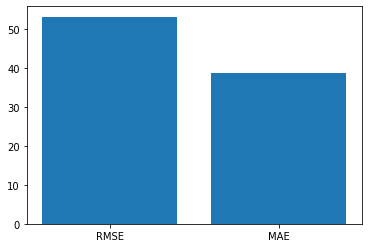

In [ ]:
from sklearn.linear_model import LinearRegression

# Model
lr_model = LinearRegression()
lr_model.fit(train_X, train_y) # 최적화식을 풀어 학습파라미티(회귀계수)를 구한다.
pred = lr_model.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

## 2.  Ridge, Lasso

* 사용한 모델
> * Ridge : 회귀계수의 크기를 0으로 가깝게 하여, X를 완전히 제거하지 않고 살려두기 위한 모델
> * Lasso : 회귀계수의 크기를 그냥 0으로 만들어버려, X를 완전히 제거하는 모델

* 학습방법
> * 모델을 하이퍼라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가. 즉, 학습데이터를 학습과 검증데이터로 쪼개는 과정을 반복하여 학습시키는 방법
>   * 참고 : https://huidea.tistory.com/30
> * 하이퍼라미터 후보 : alpha = [0.001, 0.01, 0.1, 1, 10]
>   * 하이퍼파라미터 선택을 위한 평가지표 : R2_score
>   * 참고 : R2_score의 경우, 선형회귀에서만 사용할 수 있는 지표이다. 즉, 다른 회귀모델에서는 사용불가.

* summary
> * 그냥 학습
>   * 학습에 사용하는 데이터 = train_X, train_y
>   * 테스트에 사용하는 데이터 = test_X, test_y
> * k-fold 학습
>   * 학습에 사용하는 데이터 = train_X, train_y
>   * 테스트에 사용하는 데이터 = train_X, train_y
> * k-fold를 사용하는 이유
>   * 데이터의 수가 너무 적어, test_X, test_y를 만들기 어려운 경우
>   * 하이퍼파라미터를 찾을 시에, test_X, test_y을 잘 예측하는 모델이 아닌 train_X, train_y을 잘 예측하는 모델로 하여, 과적합을 막기 위함

In [ ]:
# 데이터 전처리에 사용되는 라이브러리
from sklearn.model_selection import cross_val_score

# 규제항이 있는 선형회귀 관련 라이브러리
from sklearn.linear_model import Ridge, Lasso

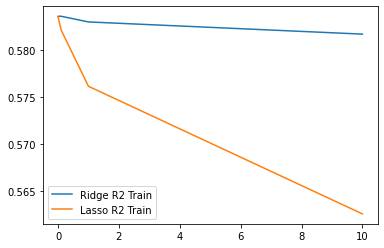

In [ ]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]


# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    


    # # 이전처럼 'k-fold학습'을 쓰지 않고, 그냥 학습
    # ridge_model.fit(train_X,train_y)
    # lasso_model.fit(train_X,train_y)
    # #테스트; sklearn.metrics에 있는 r2_score()함수를 가져와 평가
    # ridge_r2_list_test.append(r2_score(test_y,ridge_model.predict(test_X)))
    # lasso_r2_list_test.append(r2_score(test_y,lasso_model.predict(test_X)))


    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [ ]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Ridge모델에 대한 r2평가지표
ridge_r2_list_train

[0.5835370814408894,
 0.5835598975702994,
 0.5835645621850609,
 0.5829591161172232,
 0.5816632964853079]

In [ ]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Lasso모델에 대한 r2평가지표
lasso_r2_list_train

[0.5835280784514637,
 0.5834113719012438,
 0.5821142608318493,
 0.576112418978648,
 0.5625329424414238]

가장 좋은 성능이 나온 hyper-parameter값을 기준으로 모델을 제작한다.
* 이전에는 반복문을 사용하여 가장 마지막 모델이 변수안에 들어갔기에, 다시 학습이 필요함

In [ ]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx1 = np.array(ridge_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index
idx2 = np.array(lasso_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx1])
print('Lasso best alpha :', alpha_list[idx2])

Ridge best alpha : 0.1
Lasso best alpha : 0.001


각각 최적이 hyper-parameter로 학습한 후에 Ridge와 Lasso의 성능을 서로 비교하자.
* 이번에는 R2_score뿐만 아니라, 일반적으로 회귀모델들의 평가지표로써 사용되는 r-MSE & MAE도 함께 사용

In [ ]:
# 각각 alpha = 0.1, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=0.1) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=0.001)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

# 모델 평가
# R^2; r2_score
# 여기서 매우 조심해야할 사항이 있다.
# 그것은 바로 r2_score()와 mean_squared_error() 모두 인자의 순서를 주의해서 넣어주어야한다는 것이다.
# 모두 (정닶값,예측값) 순으로 넣어주어야한다.
# mse는 어차피 같은 값이 나오지만, r2_score는 조심해야한다.
print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y, ridge.predict(test_X))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y, lasso.predict(test_X))))

R square score for Ridge model : 0.55624
R square score for Lasso model : 0.55745
MSE for Ridge model : 2842.77187
MSE for Lasso model : 2835.00559


RMSE: 53.318, MAE: 38.730


<BarContainer object of 2 artists>

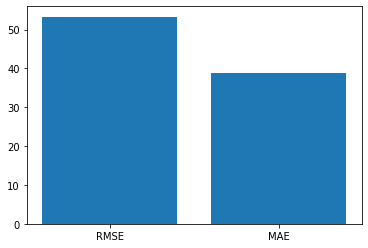

In [ ]:
pred = ridge.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

RMSE: 53.245, MAE: 38.686


<BarContainer object of 2 artists>

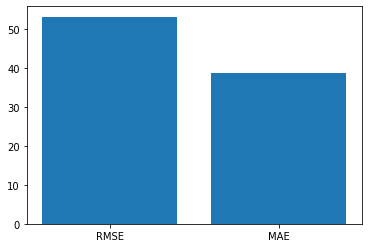

In [ ]:
pred = lasso.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

Lasso가 Ridge보다 근소한 차이로 R2_score값은 높고 RMSE값은 낮기에 더 좋은 모델이다. 따라서 해당 Lasso 모델을 선택한다.

## 변수중요도 : 회귀계수에 대한 해석

ML에서는 NN과 달리 어느 정도 설명가능한 부분이 있다. 그 중 하나가 바로 변수 중요도이다.

> 일반적으로 회귀계수의 크기가 클수록 해당 X변수의 중요도가 높다. 하지만 회귀계수의 의미를 생각하면, X변수를 스케일링에 따라 다르게 해석할 수 있다.(세션자료 참고)

> 1. 스케일링 없이
>    * 1000원짜리 김밥 1원 증가할 때와 10억원짜리 집값 1원 증가할 때, 경제지표에 미치는 영향
> 2. min-max scaling
>    * 1000원짜리 김밥가격 10% 증가할 때와 10억원짜리 집값 10% 증가할 때, 경제지표에 미치는 영향
> 3. standard scaling
>    * 데이터로 얻은 각각의 김밥과 집값의 분포에서 z-score가 일정부분 동일하게 움직였을 때의 가격 변화가 경제지표에 미치는 영향

최종적으로 선택해서 학습까지 완료시킨 ridge모델을 사용

1. 스케일링 없이

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


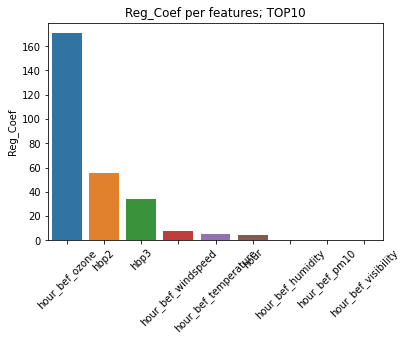

In [ ]:
# 표준화한 회귀계수의 절댓값
coef = ridge.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = X3_features.head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

2. min-max scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hbp2,hbp3,count
0,0.869565,0.490706,0.1875,0.891304,0.259105,0.196721,0.257692,1.0,0.0,0.111628


이후, 이전처럼 '데이터분할 -> 최적의 hyper-parameter선택 -> 선택된 모델로 학습 -> 변수중요도 확인' 과정을 수행

3. standard scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = StandardScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hbp2,hbp3,count
0,1.198579,-0.114422,-0.720969,1.855885,-1.459377,-0.628003,0.599678,5.705261,-0.072412,-0.749088


In [ ]:
ridge.coef_

array([ 4.71283875e+00,  5.06427769e+00,  7.66071621e+00, -4.79688026e-01,
       -1.31462007e-03,  1.70677857e+02, -3.66791635e-01, -5.58750343e+01,
        3.41595346e+01])

# 문제 1

사용할 데이터 : house.csv

네이버 부동산에서 크롤링해 가져온 서울시 부동산 데이터

* Unnamed: 0 : 의미없는 칼럼
* id : 매물id
> 한 매물당 하나의 id가 할당된다.
* lat : 위도
* lng : 경도
* gu : 구(행정지역정보)
* goodsType : 매물의 거래형태(아파트,빌라 등)
* payType : 판매의 거래형태(월세,매매 등)
* floor : 매물방의 층수
* floor_total : 매물이 있는 전체 건물의 층수
* contractArea : 계약면적
* realArea : 실제면적
* direction : 창문방향(남향,북향)
* tag : 매물마다 관련된 설명정보
> ex. 일조량 및 관리 잘 된 복층
* tagList : 매물마다 관련된 설명에서의 태그
> ex. '10년이내, 25년이내 건축, 복층'과 같이 인스타 해시테그 느낌
* deposit : 보증금
* monthlyPay : 월세


> 데이터 출처 : 네이버 부동산 크롤링 데이터

설명
* X와 y를 찾아, LinearRegression을 위 예제1을 참고하여 실행하시오.
* 예를 들면, y='보증금', X=나머지 으로 하여 나머지 값으로 보증금을 예측하는 선형회귀문제로 Task를 정해 코딩을 진행

* 조건
> * ***(핵심내용)*** X & y로 이용할 것을 명확히 제시하고, y에 따른 어떤 문제인지 파악하기
>    * y를 연속형으로 하여, LinearRegression문제가 될 수 있도록 한다.
> * X변수에 1개이상의 범주형데이터를 포함하고, one-hot encoding을 사용하기
> * 최소 1가지 이상의 방법으로 X데이터 중 1개 이상의 열을 삭제하기
> * 데이터 분할 진행하기
> * ***(핵심내용)*** 다중선형회귀 모델을 사용하기
> * 규제항이 있는 모델(Ridge,Lasso)을 사용하기
> * hyper-parameter 튜닝을 진행하기
>   * cross_val_score를 사용하지 않아도 됩니다.
>   * GridSearchCV ,RandomSearchCV을 사용하셔도 됩니다.
>   * 참고자료 : https://dacon.io/codeshare/
> * ***(핵심내용)*** 변수 중요도 해석
>   * 스케일링 없이
>   * min-max scaling
>   * standard scaling

## 1. 데이터 전처리

In [7]:
house = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSL/Session/[0131][HW]_LinearRegression_and_SVM/data/house.csv')

### 결측치 처리 및 범주형 데이터 처리

In [8]:
print(house.shape)
house.columns

(93995, 16)


Index(['Unnamed: 0', 'id', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'tag',
       'tagList', 'deposit', 'monthlyPay'],
      dtype='object')

In [9]:
house.isnull().sum()

Unnamed: 0         0
id                 0
lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
tag             4529
tagList            0
deposit            0
monthlyPay         0
dtype: int64

In [10]:
house.dtypes

Unnamed: 0        int64
id                int64
lat             float64
lng             float64
gu               object
goodsType        object
payType          object
floor             int64
floor_total       int64
contractArea      int64
realArea          int64
direction        object
tag              object
tagList          object
deposit           int64
monthlyPay        int64
dtype: object

범주형 데이터로 보이는 것은 data type이 object 인 gu, goodsType, payType, direction, tag, tagList이다. 이 때, 자연어라 추가 처리가 필요한 행인 tag, tagList 열은 제거하고, gu 역시 one-hot encoding 시 너무 많은 열이 추가될 것을 고려하여 제거하기로 결정했다. 나머지 범주형 데이터의 경우 추가 encoding을 통해 변수로 활용하고자 한다.

In [12]:
house.drop(['gu', 'tag','tagList'],axis=1, inplace=True)
house.columns

Index(['lat', 'lng', 'goodsType', 'payType', 'floor', 'floor_total',
       'contractArea', 'realArea', 'direction', 'deposit', 'monthlyPay'],
      dtype='object')

의미없는 데이터 행인 Unnamed:0, id 역시 제거하도록 한다.

In [11]:
house.drop(['Unnamed: 0','id'], axis=1, inplace=True)
house.columns

Index(['lat', 'lng', 'gu', 'goodsType', 'payType', 'floor', 'floor_total',
       'contractArea', 'realArea', 'direction', 'tag', 'tagList', 'deposit',
       'monthlyPay'],
      dtype='object')

In [13]:
house.isnull().sum()

lat                0
lng                0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
deposit            0
monthlyPay         0
dtype: int64

direction 에서 결측치 발생 시 보간하기에 적절한 방법이 없다고 판단하여 (정확히 어떤 방향성을 가지는지 알기 힘듦) direction 값이 결측된 행을 삭제하기로 하였다. 이 떄 삭제되는 행은 전체의 3.4%로 전체 경향성에 무리를 줄만한 양은 아니라고 판단했다.

In [14]:
house.isnull().any(axis=1).sum()/ house.shape[0] * 100

3.4086919516995584

In [15]:
house.dropna(axis=0, inplace=True)
house.shape

(90791, 11)

#### 더미 변수 생성하기

범주형데이터로 one-hot encoding 진행 시, 각 항목별 합이 1이 되므로 VIF가 매우 커지게 된다. 따라서, 한개의 변수를 삭제해 적절한 값을 가질 수 있도록 데이터를 변경해준다.

In [25]:
temp1 = pd.get_dummies(house.loc[:,'goodsType'])
temp1

,단독/다가구,빌라,사무실,상가,상가주택,아파트,아파트분양권,오피스텔,오피스텔분양권,원룸,재건축,전원주택
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0,0,1,0,0,0,0,0,0,0,0,0
93991,0,0,0,0,0,1,0,0,0,0,0,0
93992,1,0,0,0,0,0,0,0,0,0,0,0
93993,0,0,0,0,0,1,0,0,0,0,0,0


In [27]:
corr_test = pd.concat([temp1, house.loc[:,'deposit']],axis=1)
corr_test.corr()['deposit']

단독/다가구    -0.095549
빌라        -0.067273
사무실       -0.183826
상가        -0.211344
상가주택      -0.037046
아파트        0.461009
아파트분양권     0.015824
오피스텔      -0.073918
오피스텔분양권   -0.003505
원룸        -0.154804
재건축        0.097479
전원주택      -0.002395
deposit    1.000000
Name: deposit, dtype: float64

y변수인 deposit과의 상관관계가 가장 작은 것은 '전원주택'이므로 더미변수의 다중공선성을 고려하여 '전원주택'변수를 삭제한다.

In [28]:
temp1.drop('전원주택',axis=1, inplace=True)
temp1.columns

Index(['단독/다가구', '빌라', '사무실', '상가', '상가주택', '아파트', '아파트분양권', '오피스텔', '오피스텔분양권',
       '원룸', '재건축'],
      dtype='object')

In [29]:
house = house.drop(['goodsType'], axis=1)
house = pd.concat([house, temp1], axis=1)
house.head()

,lat,lng,payType,floor,floor_total,contractArea,realArea,direction,deposit,monthlyPay,...,빌라,사무실,상가,상가주택,아파트,아파트분양권,오피스텔,오피스텔분양권,원룸,재건축
0,37.677967,127.041725,매매,5,5,81,63,남향,63000,0,...,0,0,0,0,1,0,0,0,0,0
1,37.657623,127.044115,매매,15,24,154,119,남향,140000,0,...,0,0,0,0,1,0,0,0,0,0
2,37.645001,127.040034,전세,3,4,38,33,남향,15000,0,...,1,0,0,0,0,0,0,0,0,0
3,37.666850,127.039420,매매,5,18,107,84,남향,60000,0,...,0,0,0,0,1,0,0,0,0,0
4,37.655622,127.041475,월세,2,8,30,22,북향,700,44,...,0,1,0,0,0,0,0,0,0,0


In [33]:
temp2 = pd.get_dummies(house.loc[:,'payType'])
temp2.head()

,단기임대,매매,월세,전세
0,0,1,0,0
1,0,1,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,1,0


In [34]:
corr_test2 = pd.concat([temp2, house.loc[:,'deposit']],axis=1)
corr_test2.corr()['deposit']

단기임대      -0.043221
매매         0.447714
월세        -0.431441
전세         0.004265
deposit    1.000000
Name: deposit, dtype: float64

'전세'열이 y변수와 가장 상관성이 적으므로 '전세' 열을 삭제한다. 

In [35]:
temp2.drop('전세',axis=1, inplace=True)
house = house.drop(['payType'], axis=1)
house = pd.concat([house, temp2], axis=1)
house.head()

,lat,lng,floor,floor_total,contractArea,realArea,direction,deposit,monthlyPay,단독/다가구,...,상가주택,아파트,아파트분양권,오피스텔,오피스텔분양권,원룸,재건축,단기임대,매매,월세
0,37.677967,127.041725,5,5,81,63,남향,63000,0,0,...,0,1,0,0,0,0,0,0,1,0
1,37.657623,127.044115,15,24,154,119,남향,140000,0,0,...,0,1,0,0,0,0,0,0,1,0
2,37.645001,127.040034,3,4,38,33,남향,15000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37.666850,127.039420,5,18,107,84,남향,60000,0,0,...,0,1,0,0,0,0,0,0,1,0
4,37.655622,127.041475,2,8,30,22,북향,700,44,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
temp3 = pd.get_dummies(house.loc[:,'direction'])
temp3.head()

,남동향,남서향,남향,동향,북동향,북서향,북향,서향
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0


In [37]:
corr_test3 = pd.concat([temp3, house.loc[:,'deposit']],axis=1)
corr_test3.corr()['deposit']

남동향        0.044511
남서향        0.035360
남향         0.135139
동향        -0.061148
북동향       -0.062535
북서향       -0.060153
북향        -0.101342
서향        -0.092357
deposit    1.000000
Name: deposit, dtype: float64

'남서향'변수가 가장 상관성이 낮으므로 '남서향'변수를 삭제한다.

In [38]:
temp3.drop('남서향', axis=1, inplace=True)
house = house.drop(['direction'], axis=1)
house = pd.concat([house, temp3], axis=1)
house.head()

,lat,lng,floor,floor_total,contractArea,realArea,deposit,monthlyPay,단독/다가구,빌라,...,단기임대,매매,월세,남동향,남향,동향,북동향,북서향,북향,서향
0,37.677967,127.041725,5,5,81,63,63000,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,37.657623,127.044115,15,24,154,119,140000,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,37.645001,127.040034,3,4,38,33,15000,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,37.666850,127.039420,5,18,107,84,60000,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,37.655622,127.041475,2,8,30,22,700,44,0,0,...,0,0,1,0,0,0,0,0,1,0


#### 최종 X, y 변수 생성

(array([8.9145e+04, 1.3760e+03, 1.7600e+02, 5.2000e+01, 2.2000e+01,
        5.0000e+00, 1.2000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([      0.,  240000.,  480000.,  720000.,  960000., 1200000.,
        1440000., 1680000., 1920000., 2160000., 2400000.]),
 <a list of 10 Patch objects>)

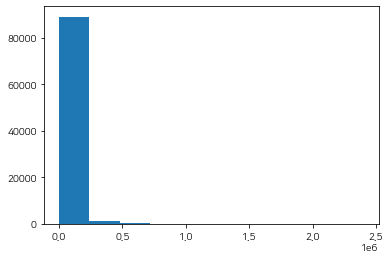

In [39]:
y_label = house.loc[:,'deposit']
y_label.value_counts()
plt.hist(y_label.values)

In [40]:
X_features = house.drop(['deposit'], axis=1)
X_features.columns

Index(['lat', 'lng', 'floor', 'floor_total', 'contractArea', 'realArea',
       'monthlyPay', '단독/다가구', '빌라', '사무실', '상가', '상가주택', '아파트', '아파트분양권',
       '오피스텔', '오피스텔분양권', '원룸', '재건축', '단기임대', '매매', '월세', '남동향', '남향', '동향',
       '북동향', '북서향', '북향', '서향'],
      dtype='object')

#### 다중공선성 확인하기 - 상관계수

In [41]:
cor_matrix = abs(X_features.corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,lat,lng,floor,floor_total,contractArea,realArea,monthlyPay,단독/다가구,빌라,사무실,...,단기임대,매매,월세,남동향,남향,동향,북동향,북서향,북향,서향
lat,0.000000,0.281044,0.038741,0.050995,0.001401,0.002711,0.003105,0.010824,0.037936,0.065812,...,0.037846,0.119177,0.061748,0.038575,0.035635,0.038810,0.018086,0.011314,0.007713,0.012712
lng,0.281044,0.000000,0.014086,0.016042,0.000117,0.009750,0.001590,0.032388,0.009789,0.025061,...,0.010597,0.010818,0.004352,0.021013,0.032419,0.031532,0.004162,0.008973,0.024655,0.027213
floor,0.038741,0.014086,0.000000,0.659679,0.000133,0.070722,0.002528,0.139202,0.230279,0.048832,...,0.009046,0.141475,0.194291,0.037179,0.067796,0.035654,0.045322,0.034896,0.063574,0.071276
floor_total,0.050995,0.016042,0.659679,0.000000,0.001801,0.087295,0.001119,0.192818,0.337180,0.093436,...,0.013614,0.165997,0.203690,0.037872,0.080861,0.044399,0.057465,0.047127,0.066624,0.077399
contractArea,0.001401,0.000117,0.000133,0.001801,0.000000,0.039653,0.001163,0.002344,0.006545,0.010505,...,0.000951,0.000947,0.004963,0.003068,0.002505,0.006045,0.004997,0.001351,0.000822,0.000856
realArea,0.002711,0.009750,0.070722,0.087295,0.039653,0.000000,0.026248,0.042408,0.111519,0.267743,...,0.017194,0.058389,0.143174,0.015803,0.011925,0.019837,0.004138,0.016957,0.034859,0.011073
monthlyPay,0.003105,0.001590,0.002528,0.001119,0.001163,0.026248,0.000000,0.001512,0.003934,0.015809,...,0.000244,0.005891,0.010420,0.002865,0.003855,0.002175,0.000788,0.000395,0.002100,0.002596
단독/다가구,0.010824,0.032388,0.139202,0.192818,0.002344,0.042408,0.001512,0.000000,0.102077,0.073276,...,0.018986,0.135744,0.051775,0.020812,0.002507,0.010988,0.001343,0.003395,0.024961,0.009367
빌라,0.037936,0.009789,0.230279,0.337180,0.006545,0.111519,0.003934,0.102077,0.000000,0.173083,...,0.011889,0.140813,0.285677,0.027063,0.043766,0.005300,0.028179,0.000439,0.037879,0.024474
사무실,0.065812,0.025061,0.048832,0.093436,0.010505,0.267743,0.015809,0.073276,0.173083,0.000000,...,0.009603,0.206258,0.398718,0.067209,0.049305,0.001200,0.042318,0.054592,0.132746,0.063667


floor와 floor_total 사이의 상관관계가 높은 것으로 나타나 둘 중 하나의 변수만 사용해도 괜찮을 것으로 보인다.

In [42]:
X2_features = X_features.drop(['floor'], axis=1)
X2_features.columns

Index(['lat', 'lng', 'floor_total', 'contractArea', 'realArea', 'monthlyPay',
       '단독/다가구', '빌라', '사무실', '상가', '상가주택', '아파트', '아파트분양권', '오피스텔', '오피스텔분양권',
       '원룸', '재건축', '단기임대', '매매', '월세', '남동향', '남향', '동향', '북동향', '북서향', '북향',
       '서향'],
      dtype='object')

#### 다중공선성 확인하기 - VIF

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 값을 저장할 데이터프레임 변수
vif = pd.DataFrame()

# 첫번째 features축은 columns이름으로
vif["features"] = X2_features.columns # 독립변수들의 이름들로 구성된 features열 추가

# 두번째 축은 VIF값을 계산하여 집어넣기
vif["VIF Factor"] = [variance_inflation_factor(X2_features.values, i) for i in range(X2_features.shape[1])] # 리스트내포

vif

,features,VIF Factor
0,lat,562810.815367
1,lng,633794.722415
2,floor_total,5.139404
3,contractArea,1.002598
4,realArea,1.444245
5,monthlyPay,1.000899
6,단독/다가구,3623.932020
7,빌라,16990.795626
8,사무실,9663.238981
9,상가,12241.726788


In [44]:
# 가장 VIF 값이 높은 변수 한개를 제거하고 다시 확인
X3_features = X2_features.drop(['lng'], axis=1)

# 값을 저장할 데이터프레임 변수
vif2 = pd.DataFrame()

# 첫번째 features축은 columns이름으로
vif2["features"] = X3_features.columns # 독립변수들의 이름들로 구성된 features열 추가

# 두번째 축은 VIF값을 계산하여 집어넣기
vif2["VIF Factor"] =[variance_inflation_factor(X3_features.values, i) for i in range(X3_features.shape[1])]

vif2

,features,VIF Factor
0,lat,77570.568570
1,floor_total,5.088687
2,contractArea,1.002598
3,realArea,1.444234
4,monthlyPay,1.000890
5,단독/다가구,3213.056965
6,빌라,15068.129153
7,사무실,8568.755278
8,상가,10862.700290
9,상가주택,429.199964


여전히 VIF 값이 10 이상인 변수가 눈에 띄므로 한번 더 변수를 삭제하고 확인

In [45]:
# 가장 VIF 값이 높은 변수 한개를 제거하고 다시 확인
X3_features = X3_features.drop(['lat'], axis=1)

# 값을 저장할 데이터프레임 변수
vif3 = pd.DataFrame()

# 첫번째 features축은 columns이름으로
vif3["features"] = X3_features.columns # 독립변수들의 이름들로 구성된 features열 추가

# 두번째 축은 VIF값을 계산하여 집어넣기
vif3["VIF Factor"] = [variance_inflation_factor(X3_features.values, i) for i in range(X3_features.shape[1])] # 리스트내포

vif3

,features,VIF Factor
0,floor_total,5.081301
1,contractArea,1.002598
2,realArea,1.444220
3,monthlyPay,1.000888
4,단독/다가구,1.376339
5,빌라,2.686723
6,사무실,3.146806
7,상가,3.341081
8,상가주택,1.052802
9,아파트,7.439656


이제 모든 변수의 다중공선성이 10 이하이므로 이대로 모델링 진행

#### 통계적 검정을 통해 변수 상태 확인

In [46]:
# Linear Regression모델 적용 시, 통계적 정보를 주는 라이브러리(기초세션의 통계적사고에서 다룸)
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 상수항을 추가한 다중선형회귀
# 기초세션의 '통계적사고'에서 다룬 선형회귀 내용을 가져와 사용

X_constant = sm.add_constant(X3_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     2610.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:07:07   Log-Likelihood:            -1.1171e+06
No. Observations:               90791   AIC:                         2.234e+06
Df Residuals:                   90765   BIC:                         2.234e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.077e+04   5.34e+04      0.576      0.564   -7.39e+04    1.35e+05
floor_total   1263.1404     27.025     46.740      0.000    1210.172    1316.109
contractArea     0.0163      0.038      0.434      0.664      -0.057       0.090
realArea        96.2834      1.273     75.664      0.000      93.789      98.778
monthlyPay      -0.0037      0.004     -0.889      0.374      -0.012       0.004
단독/다가구       -6787.0758   5.34e+04     -0.127      0.899   -1.11e+05    9.78e+04
빌라           -1.594e+04   5.34e+04     -0.299      0.765   -1.21e+05    8.87e+04
사무실          -1.957e+04   5.34e+04     -0.367      0.714   -1.24e+05    8.51e+04
상가           -9276.9408   5.34e+04     -0.174      0.862   -1.14e+05    9.53e+04
상가주택         -8765.8584   5.34e+04     -0.164      0.870   -1.13e+05     9.6e+04
아파트           1.423e+04   5.34e+04      0.266      0.790   -9.04e+04    1.19e+05
아파트분양권        9855.7802   5.34e+04      0.184      0.854   -9.49e+04    1.15e+05
오피스텔         -3.272e+04   5.34e+04     -0.613      0.540   -1.37e+05    7.19e+04
오피스텔분양권      -2.296e+04   5.35e+04     -0.429      0.668   -1.28e+05     8.2e+04
원룸           -1.419e+04   5.34e+04     -0.266      0.790   -1.19e+05    9.04e+04
재건축           7.013e+04   5.34e+04      1.313      0.189   -3.46e+04    1.75e+05
단기임대         -3.229e+04   2875.312    -11.231      0.000   -3.79e+04   -2.67e+04
매매            3.842e+04    468.116     82.075      0.000    3.75e+04    3.93e+04
월세           -3.053e+04    553.392    -55.163      0.000   -3.16e+04   -2.94e+04
남동향           1080.2816    624.551      1.730      0.084    -143.833    2304.396
남향            5617.2215    561.367     10.006      0.000    4516.948    6717.495
동향           -5931.0155    662.046     -8.959      0.000   -7228.619   -4633.412
북동향           -512.7653   1008.630     -0.508      0.611   -2489.669    1464.139
북서향           -964.3176   1087.215     -0.887      0.375   -3095.248    1166.613
북향           -3125.6413    909.676     -3.436      0.001   -4908.597   -1342.685
서향           -4493.5997    799.860     -5.618      0.000   -6061.316   -2925.883
==============================================================================
Omnibus:                   138856.655   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        138016296.855
Skew:                           9.371   Prob(JB):                         0.00
Kurtosis:                     193.085   Cond. No.                     4.44e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

p = 0.05 하에서 H0 (회귀 계수가 0이다)을 기각하지 못하는 변수가 발견되었으므로 해당 변수는 삭제하도록 한다. 먼저 가장 p값이 크게 나타난 '상가'변수를 삭제해보도록 한다.

In [47]:
X4_features = X3_features.drop('상가', axis=1)
X4_features.columns

Index(['floor_total', 'contractArea', 'realArea', 'monthlyPay', '단독/다가구', '빌라',
       '사무실', '상가주택', '아파트', '아파트분양권', '오피스텔', '오피스텔분양권', '원룸', '재건축', '단기임대',
       '매매', '월세', '남동향', '남향', '동향', '북동향', '북서향', '북향', '서향'],
      dtype='object')

In [48]:
X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     2719.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:07:32   Log-Likelihood:            -1.1171e+06
No. Observations:               90791   AIC:                         2.234e+06
Df Residuals:                   90766   BIC:                         2.234e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.149e+04    865.410     24.834      0.000    1.98e+04    2.32e+04
floor_total   1263.1331     27.025     46.740      0.000    1210.165    1316.101
contractArea     0.0163      0.038      0.434      0.664      -0.057       0.090
realArea        96.2830      1.273     75.664      0.000      93.789      98.777
monthlyPay      -0.0037      0.004     -0.889      0.374      -0.012       0.004
단독/다가구        2489.1811   1028.923      2.419      0.016     472.503    4505.860
빌라           -6665.8481    743.455     -8.966      0.000   -8123.013   -5208.683
사무실           -1.03e+04    727.315    -14.158      0.000   -1.17e+04   -8871.952
상가주택           510.3980   2443.038      0.209      0.835   -4277.933    5298.729
아파트            2.35e+04    763.819     30.769      0.000     2.2e+04     2.5e+04
아파트분양권        1.913e+04   2619.791      7.303      0.000     1.4e+04    2.43e+04
오피스텔         -2.344e+04    978.557    -23.958      0.000   -2.54e+04   -2.15e+04
오피스텔분양권      -1.368e+04   4217.495     -3.245      0.001    -2.2e+04   -5417.684
원룸           -4914.4890    910.031     -5.400      0.000   -6698.141   -3130.837
재건축           7.941e+04   2368.097     33.533      0.000    7.48e+04    8.41e+04
단기임대         -3.229e+04   2875.297    -11.231      0.000   -3.79e+04   -2.67e+04
매매            3.842e+04    468.114     82.076      0.000    3.75e+04    3.93e+04
월세           -3.053e+04    553.389    -55.163      0.000   -3.16e+04   -2.94e+04
남동향           1080.2865    624.548      1.730      0.084    -143.822    2304.395
남향            5617.2203    561.364     10.006      0.000    4516.952    6717.488
동향           -5931.0535    662.042     -8.959      0.000   -7228.650   -4633.457
북동향           -512.8342   1008.624     -0.508      0.611   -2489.728    1464.059
북서향           -964.4041   1087.209     -0.887      0.375   -3095.323    1166.515
북향           -3125.7771    909.671     -3.436      0.001   -4908.723   -1342.831
서향           -4492.3586    799.823     -5.617      0.000   -6060.005   -2924.713
==============================================================================
Omnibus:                   138856.682   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        138016276.680
Skew:                           9.371   Prob(JB):                         0.00
Kurtosis:                     193.085   Cond. No.                     1.02e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# 여전히 큰 P 값을 가지는 변수를 삭제한다.
X4_features = X4_features.drop('contractArea', axis=1)
X4_features.columns
X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     2837.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:07:59   Log-Likelihood:            -1.1171e+06
No. Observations:               90791   AIC:                         2.234e+06
Df Residuals:                   90767   BIC:                         2.234e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.149e+04    865.375     24.839      0.000    1.98e+04    2.32e+04
floor_total  1263.1577     27.024     46.741      0.000    1210.190    1316.125
realArea       96.3034      1.272     75.732      0.000      93.811      98.796
monthlyPay     -0.0037      0.004     -0.889      0.374      -0.012       0.004
단독/다가구       2486.5008   1028.900      2.417      0.016     469.868    4503.134
빌라          -6669.4892    743.405     -8.972      0.000   -8126.555   -5212.424
사무실          -1.03e+04    727.298    -14.161      0.000   -1.17e+04   -8873.935
상가주택          507.7468   2443.020      0.208      0.835   -4280.548    5296.042
아파트           2.35e+04    763.762     30.766      0.000     2.2e+04     2.5e+04
아파트분양권       1.913e+04   2619.768      7.302      0.000     1.4e+04    2.43e+04
오피스텔        -2.345e+04    978.520    -23.963      0.000   -2.54e+04   -2.15e+04
오피스텔분양권     -1.369e+04   4217.468     -3.245      0.001    -2.2e+04   -5421.401
원룸          -4917.3396    910.003     -5.404      0.000   -6700.937   -3133.742
재건축          7.941e+04   2368.071     33.532      0.000    7.48e+04     8.4e+04
단기임대        -3.229e+04   2875.284    -11.232      0.000   -3.79e+04   -2.67e+04
매매           3.842e+04    468.109     82.078      0.000    3.75e+04    3.93e+04
월세          -3.053e+04    553.378    -55.166      0.000   -3.16e+04   -2.94e+04
남동향          1080.3094    624.545      1.730      0.084    -143.793    2304.412
남향           5617.3051    561.362     10.007      0.000    4517.042    6717.568
동향          -5929.5513    662.030     -8.957      0.000   -7227.124   -4631.978
북동향          -510.8699   1008.610     -0.507      0.613   -2487.735    1465.995
북서향          -964.1765   1087.204     -0.887      0.375   -3095.086    1166.733
북향          -3126.2692    909.666     -3.437      0.001   -4909.206   -1343.333
서향          -4492.6798    799.819     -5.617      0.000   -6060.318   -2925.042
==============================================================================
Omnibus:                   138856.626   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        138016525.795
Skew:                           9.371   Prob(JB):                         0.00
Kurtosis:                     193.085   Cond. No.                     1.02e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
X4_features = X4_features.drop('북동향', axis=1)
X4_features.columns
X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     2966.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:08:11   Log-Likelihood:            -1.1171e+06
No. Observations:               90791   AIC:                         2.234e+06
Df Residuals:                   90768   BIC:                         2.234e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.136e+04    826.072     25.862      0.000    1.97e+04     2.3e+04
floor_total  1263.1126     27.024     46.740      0.000    1210.146    1316.079
realArea       96.3079      1.272     75.738      0.000      93.816      98.800
monthlyPay     -0.0037      0.004     -0.888      0.374      -0.012       0.004
단독/다가구       2505.2336   1028.231      2.436      0.015     489.912    4520.555
빌라          -6654.6488    742.824     -8.959      0.000   -8110.576   -5198.721
사무실          -1.03e+04    727.294    -14.160      0.000   -1.17e+04   -8873.141
상가주택          530.6366   2442.592      0.217      0.828   -4256.819    5318.092
아파트          2.353e+04    760.579     30.941      0.000     2.2e+04     2.5e+04
아파트분양권       1.919e+04   2617.266      7.331      0.000    1.41e+04    2.43e+04
오피스텔        -2.345e+04    978.504    -23.960      0.000   -2.54e+04   -2.15e+04
오피스텔분양권     -1.367e+04   4217.368     -3.242      0.001   -2.19e+04   -5408.217
원룸          -4909.1241    909.855     -5.396      0.000   -6692.431   -3125.817
재건축          7.944e+04   2367.307     33.555      0.000    7.48e+04    8.41e+04
단기임대        -3.229e+04   2875.235    -11.229      0.000   -3.79e+04   -2.67e+04
매매           3.842e+04    468.100     82.082      0.000    3.75e+04    3.93e+04
월세          -3.053e+04    553.375    -55.166      0.000   -3.16e+04   -2.94e+04
남동향          1188.7665    586.689      2.026      0.043      38.862    2338.671
남향           5725.2828    519.306     11.025      0.000    4707.448    6743.118
동향          -5816.2729    623.108     -9.334      0.000   -7037.559   -4594.987
북서향          -842.6436   1060.392     -0.795      0.427   -2921.002    1235.714
북향          -3001.5552    875.706     -3.428      0.001   -4717.930   -1285.181
서향          -4373.0244    764.133     -5.723      0.000   -5870.717   -2875.331
==============================================================================
Omnibus:                   138851.409   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        137977986.572
Skew:                           9.371   Prob(JB):                         0.00
Kurtosis:                     193.059   Cond. No.                     1.02e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
X4_features = X4_features.drop(['monthlyPay', '북서향','상가주택'], axis=1)
X4_features.columns
X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     3434.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:08:45   Log-Likelihood:            -1.1171e+06
No. Observations:               90791   AIC:                         2.234e+06
Df Residuals:                   90771   BIC:                         2.234e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.125e+04    791.270     26.853      0.000    1.97e+04    2.28e+04
floor_total  1262.9453     27.017     46.746      0.000    1209.992    1315.899
realArea       96.2699      1.271     75.739      0.000      93.779      98.761
단독/다가구       2505.5556   1020.895      2.454      0.014     504.611    4506.500
빌라          -6656.1665    731.740     -9.096      0.000   -8090.370   -5221.962
사무실         -1.032e+04    721.991    -14.295      0.000   -1.17e+04   -8905.554
아파트          2.355e+04    749.871     31.410      0.000    2.21e+04     2.5e+04
아파트분양권       1.923e+04   2613.200      7.357      0.000    1.41e+04    2.43e+04
오피스텔        -2.347e+04    972.372    -24.139      0.000   -2.54e+04   -2.16e+04
오피스텔분양권      -1.37e+04   4216.005     -3.249      0.001    -2.2e+04   -5432.861
원룸          -4916.0204    902.574     -5.447      0.000   -6685.056   -3146.985
재건축          7.945e+04   2363.736     33.611      0.000    7.48e+04    8.41e+04
단기임대        -3.231e+04   2875.041    -11.237      0.000   -3.79e+04   -2.67e+04
매매           3.842e+04    467.493     82.176      0.000    3.75e+04    3.93e+04
월세          -3.054e+04    551.592    -55.370      0.000   -3.16e+04   -2.95e+04
남동향          1313.2700    565.791      2.321      0.020     204.325    2422.215
남향           5848.3263    495.521     11.802      0.000    4877.110    6819.542
동향          -5686.5470    601.314     -9.457      0.000   -6865.116   -4507.978
북향          -2861.0339    855.824     -3.343      0.001   -4538.440   -1183.628
서향          -4238.6985    744.014     -5.697      0.000   -5696.959   -2780.438
==============================================================================
Omnibus:                   138852.432   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        137993390.113
Skew:                           9.371   Prob(JB):                         0.00
Kurtosis:                     193.069   Cond. No.                     3.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 데이터 분할 및 평가함수 준비

In [52]:
from sklearn.model_selection import train_test_split

# X3_features 사용; X4_features의 경우, 학습이후에 만들어진 데이터임으로

train_X, test_X, train_y, test_y = train_test_split(X3_features, y_label, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(72632, 25) (18159, 25) (72632,) (18159,)


In [53]:
# 회귀(y값이 연속형변수)의 평가지표

from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    # MSE는 제곱이기에 값이 큼으로 r-MSE(root)를 이용한다.
    # MSE는 scikit-learn의 mean_squared_error()로 계산
    rmse_val = np.sqrt(mean_squared_error(y,pred))
    # MAE는 scikit-learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)

    # (r-MSE & MAE)를 출력 후, 반환해주는 함수
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))
    return (rmse_val, mae_val)

## Linear Regression

RMSE: 54903.832, MAE: 25256.363


<BarContainer object of 2 artists>

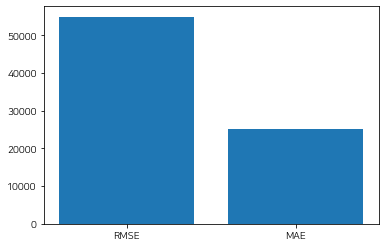

In [54]:
from sklearn.linear_model import LinearRegression

# Model
lr_model = LinearRegression()
lr_model.fit(train_X, train_y) # 최적화식을 풀어 학습파라미티(회귀계수)를 구한다.
pred = lr_model.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

### Ridge, Lasso

In [55]:
# 데이터 전처리에 사용되는 라이브러리
from sklearn.model_selection import cross_val_score

# 규제항이 있는 선형회귀 관련 라이브러리
from sklearn.linear_model import Ridge, Lasso

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.22699e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.399e+13, tolerance: 3.168e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e+13, tolerance: 3.145e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent

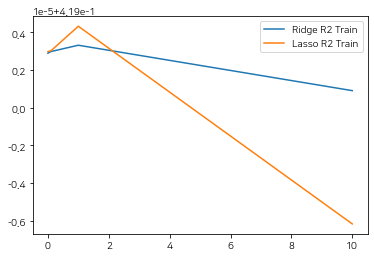

In [60]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]


# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()


In [61]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Ridge모델에 대한 r2평가지표
ridge_r2_list_train

[0.4190028871869974,
 0.41900289909846167,
 0.41900297466843883,
 0.41900331050765904,
 0.41900089825058123]

In [62]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Lasso모델에 대한 r2평가지표
lasso_r2_list_train

[0.4190029749290366,
 0.41900297909793294,
 0.4190030145234246,
 0.41900431885556877,
 0.41899381887148957]

In [63]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx1 = np.array(ridge_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index
idx2 = np.array(lasso_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx1])
print('Lasso best alpha :', alpha_list[idx2])

Ridge best alpha : 1
Lasso best alpha : 1


In [64]:
# 각각 alpha = 1, 1으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=1) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=1)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

# 모델 평가
print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y, ridge.predict(test_X))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y, lasso.predict(test_X))))

R square score for Ridge model : 0.41041
R square score for Lasso model : 0.41041
MSE for Ridge model : 3014477048.28066
MSE for Lasso model : 3014487377.61072


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.798e+11, tolerance: 3.516e+10
  model = cd_fast.enet_coordinate_descent(


RMSE: 54904.253, MAE: 25255.945


<BarContainer object of 2 artists>

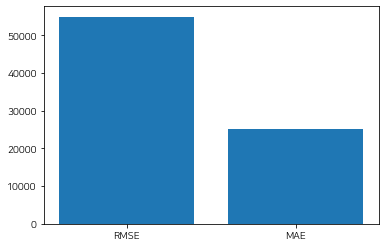

In [65]:
pred = ridge.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

RMSE: 54904.348, MAE: 25254.348


<BarContainer object of 2 artists>

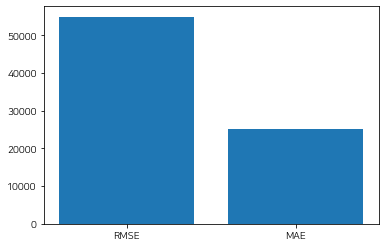

In [66]:
pred = lasso.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

Ridge가 근소하게 LASSO보다 낮은 RMSE 값을 보인다. 또한, R2-score 값은 동일하므로 Ridge가 조금 더 좋은 모델인 것으로 판단된다.

### 변수 중요도 해석

##### 1. without scaling

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


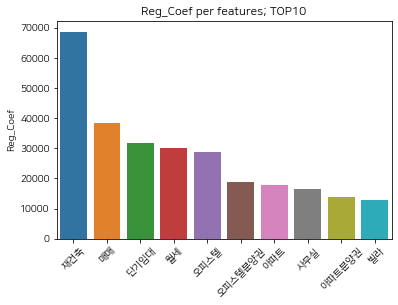

In [67]:
# 표준화한 회귀계수의 절댓값
coef = ridge.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = X3_features.head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

##### 2. min-max scaling

In [68]:
from sklearn.preprocessing import MinMaxScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,floor_total,contractArea,realArea,monthlyPay,단독/다가구,빌라,사무실,상가,상가주택,아파트,...,매매,월세,남동향,남향,동향,북동향,북서향,북향,서향,deposit
0,0.00489,0.000059,0.005172,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.02625


In [69]:
trans_x = trans_data_df.drop(['deposit'],axis=1)
trans_y = trans_data_df.loc[:,'deposit']

In [70]:
train_X2, test_X2, train_y2, test_y2 = train_test_split(trans_x, trans_y, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X2.shape, test_X2.shape, train_y2.shape, test_y2.shape)

(72632, 25) (18159, 25) (72632,) (18159,)


RMSE: 0.023, MAE: 0.011


<BarContainer object of 2 artists>

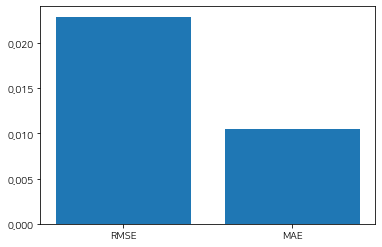

In [71]:
# Model
lr_model2 = LinearRegression()
lr_model2.fit(train_X2, train_y2) 
pred2 = lr_model2.predict(test_X2) 

result2 = evaluate_regr(test_y2, pred2) 
plt.bar(['RMSE','MAE'], result2)

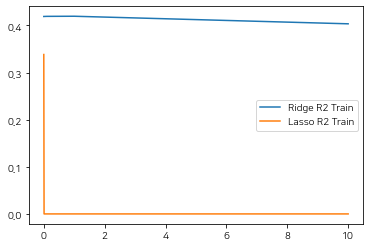

In [72]:
# alpha list 그대로 사용

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train2 = []
ridge_r2_list_test2 = []
lasso_r2_list_train2 = []
lasso_r2_list_test2 = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    
    ridge_r2_list_train2.append(np.mean(cross_val_score(ridge_model,train_X2,train_y2,scoring='r2',cv=10)))
    lasso_r2_list_train2.append(np.mean(cross_val_score(lasso_model,train_X2,train_y2,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train2, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train2, label='Lasso R2 Train')

plt.legend()


In [73]:
ridge_r2_list_train2

[0.41900728768104284,
 0.419043776567072,
 0.419265936687227,
 0.41950236742035985,
 0.40344679303287645]

In [74]:
lasso_r2_list_train2

[0.33827581572299303,
 -8.615285387088e-05,
 -8.615285387088e-05,
 -8.615285387088e-05,
 -8.615285387088e-05]

In [75]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인 : r2 점수가 높을 수록 좋음

idx3 = np.array(ridge_r2_list_train2).argsort()[::-1][0] # 가장 큰 것의 index
idx4 = np.array(lasso_r2_list_train2).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx3])
print('Lasso best alpha :', alpha_list[idx4])

Ridge best alpha : 1
Lasso best alpha : 0.001


In [78]:
# 각각 alpha = 1, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge2 = Ridge(alpha=1) 
lasso2 = Lasso(alpha=0.001)

ridge2.fit(train_X2, train_y2)
lasso2.fit(train_X2, train_y2)

# 모델 평가

print("R square score for Ridge model : {:.5f}".format(r2_score(test_y2, ridge2.predict(test_X2))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y2, lasso2.predict(test_X2))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y2, ridge2.predict(test_X2))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y2, lasso2.predict(test_X2))))

R square score for Ridge model : 0.40981
R square score for Lasso model : 0.31619
MSE for Ridge model : 0.00052
MSE for Lasso model : 0.00061


RMSE: 0.023, MAE: 0.010


<BarContainer object of 2 artists>

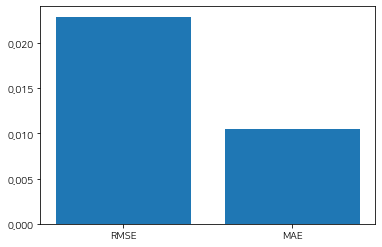

In [80]:
pred2 = ridge2.predict(test_X2) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result2 = evaluate_regr(test_y2, pred2) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result2)

RMSE: 0.025, MAE: 0.011


<BarContainer object of 2 artists>

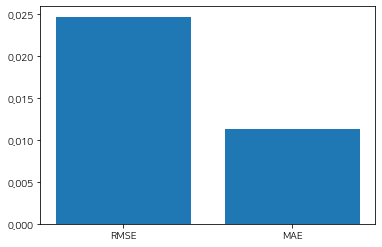

In [79]:
pred2 = lasso2.predict(test_X2) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result2 = evaluate_regr(test_y2, pred2) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result2)

R square score은 ridge 모델이, MSE 값은 lasso 모델이 높은 것으로 나타난다. 회귀모델의 유효성 판단 시 RMSE 값을 주로 평가지표로 사용하므로 여기서는 RMSE값을 기준으로 더 나은 모델을 선정하도록 하여, Lasso 모델을 고르도록 하겠다. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


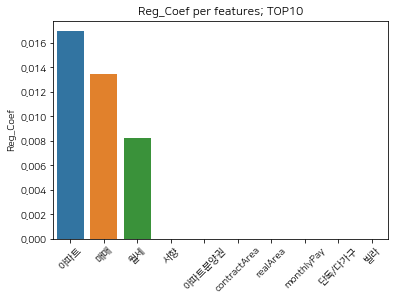

In [84]:
# 표준화한 회귀계수의 절댓값
coef2 = lasso2.coef_
coef_abs2 = np.abs(coef2)

# 회귀계수의 절댓값 크기 index
idx2 = coef_abs2.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs2 = coef_abs2[idx2]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name2 = X3_features.head(1).columns[idx2].values

# top10
sns.barplot(name2[0:10], coef_abs2[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

lasso 모델의 경우 회귀계수가 0으로 수렴할 수 있어 변수 선택에 도움을 준다. 해당 모델에서는 아파트, 매매, 월세 변수 외의 다른 변수들의 계수가 0으로 수렴하고 있어 큰 효력을 보이지 못했음을 의미한다.

##### 3. standard scaling

In [85]:
from sklearn.preprocessing import StandardScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = StandardScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,floor_total,contractArea,realArea,monthlyPay,단독/다가구,빌라,사무실,상가,상가주택,아파트,...,매매,월세,남동향,남향,동향,북동향,북서향,북향,서향,deposit
0,-0.751729,-0.010378,-0.114482,-0.00833,-0.207882,-0.491031,-0.35249,-0.40346,-0.07449,1.27321,...,1.414167,-0.79677,-0.469441,1.451823,-0.410831,-0.20507,-0.186223,-0.243731,-0.29091,0.171719


In [86]:
trans_x2 = trans_data_df.drop(['deposit'],axis=1)
trans_y2 = trans_data_df.loc[:,'deposit']

In [87]:
train_X3, test_X3, train_y3, test_y3 = train_test_split(trans_x2, trans_y2, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X3.shape, test_X3.shape, train_y3.shape, test_y3.shape)

(72632, 25) (18159, 25) (72632,) (18159,)


RMSE: 0.785, MAE: 0.361


<BarContainer object of 2 artists>

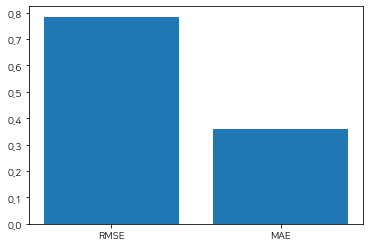

In [88]:
# Model
lr_model3 = LinearRegression()
lr_model3.fit(train_X3, train_y3) 
pred3 = lr_model3.predict(test_X3) 

result3 = evaluate_regr(test_y3, pred3) 
plt.bar(['RMSE','MAE'], result3)

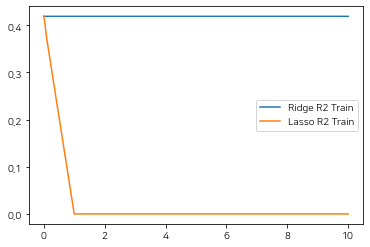

In [89]:
# alpha list 그대로 사용

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train3 = []
ridge_r2_list_test3 = []
lasso_r2_list_train3 = []
lasso_r2_list_test3 = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    
    ridge_r2_list_train3.append(np.mean(cross_val_score(ridge_model,train_X3,train_y3,scoring='r2',cv=10)))
    lasso_r2_list_train3.append(np.mean(cross_val_score(lasso_model,train_X3,train_y3,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train3, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train3, label='Lasso R2 Train')

plt.legend()


In [90]:
ridge_r2_list_train3

[0.41900284645167646,
 0.4190028498217931,
 0.4190028828282021,
 0.41900317374939033,
 0.41900562814319653]

In [91]:
lasso_r2_list_train3

[0.41916732651274263,
 0.41798174780038416,
 0.37079778466396834,
 -8.615285387088e-05,
 -8.615285387088e-05]

In [92]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx5 = np.array(ridge_r2_list_train3).argsort()[::-1][0] # 가장 큰 것의 index
idx6 = np.array(lasso_r2_list_train3).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx5])
print('Lasso best alpha :', alpha_list[idx6])

Ridge best alpha : 10
Lasso best alpha : 0.001


In [94]:
# 각각 alpha = 10, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge3 = Ridge(alpha=10) 
lasso3 = Lasso(alpha=0.001)

ridge3.fit(train_X3, train_y3)
lasso3.fit(train_X3, train_y3)

# 모델 평가

print("R square score for Ridge model : {:.5f}".format(r2_score(test_y3, ridge3.predict(test_X3))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y3, lasso3.predict(test_X3))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y3, ridge3.predict(test_X3))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y3, lasso3.predict(test_X3))))

R square score for Ridge model : 0.41042
R square score for Lasso model : 0.41034
MSE for Ridge model : 0.61581
MSE for Lasso model : 0.61590


RMSE: 0.785, MAE: 0.361


<BarContainer object of 2 artists>

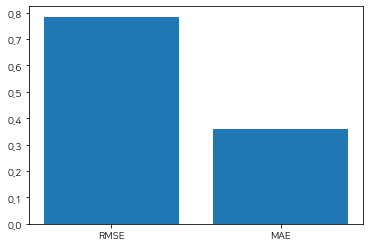

In [96]:
pred3 = ridge3.predict(test_X3) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result3 = evaluate_regr(test_y3, pred3) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result3)

RMSE: 0.785, MAE: 0.360


<BarContainer object of 2 artists>

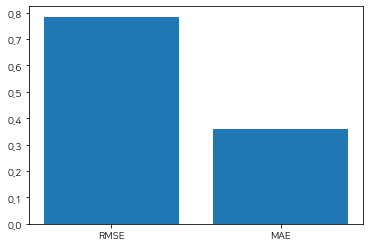

In [95]:
pred3 = lasso3.predict(test_X3) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result3 = evaluate_regr(test_y3, pred3) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result3)

이 때의 두 모델의 경우, RMSE와 R2 score에서 비슷한 값을 가지며 전자는 ridge 모델이, 후자는 LASSO 모델이 근소하게 높은 것으로 나타났다. 이번에는 ridge 모델을 선택해 변수의 중요도를 분석해보고자 한다.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


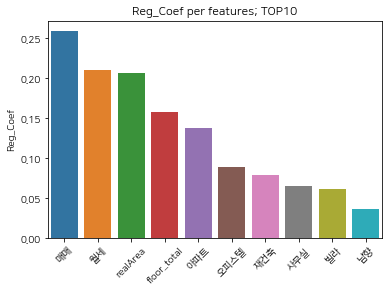

In [97]:
# 표준화한 회귀계수의 절댓값
coef3 = ridge3.coef_
coef_abs3 = np.abs(coef3)

# 회귀계수의 절댓값 크기 index
idx3 = coef_abs3.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs3 = coef_abs3[idx3]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name3 = X3_features.head(1).columns[idx3].values

# top10
sns.barplot(name3[0:10], coef_abs3[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

결과를 보면 매매, 월세 등의 구매 유형 변수가 가장 큰 영향력을 미침을 확인할 수 있다. 그 뒤를 이어, 면적 넓이, 층수 등의 물리적인 정보가 보증금을 결정하는데 영향을 준다는 것을 확인할 수 있었다. 추가적으로, standard scaling진행을 통해 전체적으로 r2 점수가 증가한 것을 확인할 수 있어, 회귀분석에서 스케일링의 중요성 역시 볼 수 있다.

# 예제 2

데이터의 y값이 '연속형' -> '범주형'만 바뀔뿐 이후에 진행하는 절차는 유사하다.

위에서 사용한 데이터를 그대로 이용한다.
* 단, 이전에는 y값을 'count'라는 연속형 데이터로 선정하여, supervised & regression 문제였으나
* 이번에는 y값을 'precipitation'라는 범주형 데이터로 선정하여, supervised & classification 문제로 변경된다.

## remark; 데이터 소개 again

사용할 데이터 : bike.csv

주어진 데이터는 서울시 공공데이터인 자전거 대여 수를 나타낸 데이터로 아래와 같다. 데이터에는 자전거 대여 수와 함께 ID, 시간, 날씨 등의 정보를 포함하고 있다.

서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터
즉, 따릉이 보관소별로 매일 자전거 대여

* id : 마포구에 있는 따릉이 보관소의 고유 id
* hour : 따릉이 보관소에서 기상상황을 측정한 시간
> ex. hour=23일 경우, 23시에 기상상황을 측정했다는 의미
* temperature : 기온
* precipitation : 비가 오지 않았으면 0, 비가 오면 1, null은 비가 온 것도 아니고 안 온 것도 아니라서 센서가 확실히 측정불가한 상태
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존
* pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 측정한 날짜의 따릉이 대여 수

> 데이터 출처 : https://www.dacon.io/competitions/open/235576/data

## 데이터 불러오기

In [103]:
path = '/content/drive/MyDrive/Colab Notebooks/DSL/Session/[0131][HW]_LinearRegression_and_SVM/data/bike.csv'
bike = pd.read_csv(path)
bike.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431


## 어떤 Task인지 파악하기

데이터 구조 확인 및 어떤 task인지 파악을 한다.

In [104]:
# (행,열)
# 행의 수 = 데이터(표본)의 갯수 = 1459
# 열의 수 = features들의 갯수 = 11

bike.shape

(1459, 11)

In [105]:
# features 살펴보기

bike.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

(array([1404.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          46.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

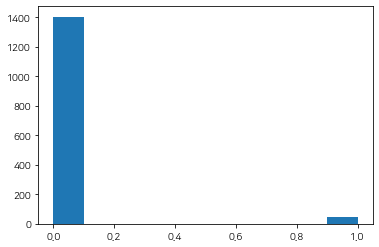

In [106]:
# y값 = 'hour_bef_precipitation(비가 왔는지 안왔는지 여부)'열

# y(label)값 뜯어내기
y_label = bike.loc[:,'hour_bef_precipitation']

# y값 분포 확인
y_label.value_counts()
plt.hist(y_label.values)

# 결론
# y값 = exist -> Supervised
# y값 = 범주형 -> classification

In [107]:
# 범주형 데이터(hour_bef_precipitation) 살펴보기

bike.loc[:,'hour_bef_precipitation'].value_counts()

# 해당 데이터의 경우, '0 or 1'인 binary-class를 갖는다.
# 따라서 해당 문제는 binary-classification task로 생각할 수 있다.

0.0    1404
1.0      46
Name: hour_bef_precipitation, dtype: int64

In [108]:
# 위의 y값을 제외한 진정한 X값들로 이루어진 features 만들기

X_features = bike.drop(['hour_bef_precipitation'], axis=1)
X_features.columns # 10개의 열들이 진정한 X_features로 사용

# 즉, 10개의 X_features열들로 1개의 y_label인 'hour_bef_precipitation'를 맞추는 문제
# 여기서 행은 데이터의 갯수, 즉 이러한 갯수의 데이터를 이용해 학습을 시킨다는 의미

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone',
       'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [109]:
# X_features 열들이 ['연속형','범주형']인지 확인

# 1~5번째 행(데이터)
X_features.head()

# 범주형 데이터 : 없음
# 연속형 데이터 : 나머지

,id,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.5,89.0,576.0,0.027,76.0,33.0,49
1,6,13,20.1,1.4,48.0,916.0,0.042,73.0,40.0,159
2,7,6,13.9,0.7,79.0,1382.0,0.033,32.0,19.0,26
3,8,23,8.1,2.7,54.0,946.0,0.040,75.0,64.0,57
4,9,18,29.5,4.8,7.0,2000.0,0.057,27.0,11.0,431


* 지금까지 배운 모델 중 binary-classification 문제를 풀 수 있는 모델은 '로지스틱회귀'와 'SVM'이다.

> * 로지스틱회귀나 SVM의 경우에도, X값 중에 범주형 데이터가 있을 경우에
> * label_encoding -> one-hot_encoding으로 바꾸어주어야한다.

> * 범주형 데이터 : 'hour_bef_precipitation'
> * 연속형 데이터 : 나머지

## 데이터 전처리하기(1)
* 결측치 파악

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

데이터 전처리의 경우, 개인의 논리와 그간의 데이터 분석경험에 따라 어느 정도 바뀌어질 수 있다. 따라서 이번 시간에 제시된 방법이 정답은 아니고, 하나의 방법으로 제시하는 측면이라는 걸 확인해주길 바랍니다.

### 결측치 처리

In [110]:
# 항상 결측치가 있는지 확인이 필요하다.

bike.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      9
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

질문 : 결측치를 어떻게 처리할 것인가?

y값인 범주형 축(hour_bef_precipitation)의 경우,

* 데이터 구조 : 0과 1인 class에 대부분의 값이 속해있고, 2개의 값은 null값이다.

* 처리 방법
> 1. null이 있는 행을 제거한다.
> 2. null이 있는 값을 최빈값으로 바꾼다.
> 3. null이 있는 값을 새로운 class로 대입한다.

이전문제에서는 3번의 방법을 사용하여 binary-class를 3개의 class로 바꾸었다. 그러나 우리가 배운 것은 binary-class를 분류하는 방법인 logistic-regression과 svm임으로, 1 또는 2 방법을 사용해 binary-class를 유지해야한다. 따라서 이번 문제에서는 1번 방법을 사용하도록 하자.(2번 방법을 사용해도 됩니다.)



X의 경우에도 이전과 다르게 결측치의 갯수에 따라 나누지 않고, null값을 가진 데이터를 모두 제거하도록 하자.

* 해당 방법의 경우, null값의 갯수가 총 데이터의 갯수보다 적으면 사용할 수 있는 기법이다.
* 만약 null값의 갯수가 많은데 null값을 가진 행을 삭제한다면, 남은 데이터는 얼마 없을 것이다.

In [111]:
# 총 데이터의 수(=행의 크기)

bike.shape[0]

1459

In [112]:
# null값을 가진 데이터의 수(=null값이 하나라도 있는 행의 크기)

bike.isnull().any(axis=1).sum()

138

In [113]:
# null값의 비율

bike.isnull().any(axis=1).sum() / bike.shape[0] * 100

9.458533241946538

대략 10%임으로 사실 null값이 많다고 볼 수 있지만, 위 regression에서 방법을 설명하였기에 여기서는 그냥 null값이 하나라도 있는 행을 제거하도록 한다.

In [114]:
bike.dropna(axis=0, inplace=True)

In [115]:
bike.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [116]:
# index 정리

bike.reset_index(drop=True, inplace=True) # drop : index열을 만들것인지 여부
bike.index

RangeIndex(start=0, stop=1321, step=1)

## 데이터 전처리하기(2)
* 범주형 X 데이터 처리 및 변수제거

사실상 ML에서는 데이터 전처리를 하는데 가장 오랜시간이 걸린다.

### 1. 범주형 X데이터 처리

해당 문제의 경우, 유일하게 범주형 변수였던 'hour_bef_precipitation'이 y값으로 사용되었기에, 따로 범주형 자료에 대한 one-hot_encoding은 필요없다. 만약 다른 데이터로 진행하여 X값 중에 범주형자료가 있다면 수행해주어야하는 절차이다.

In [117]:
# X & y 나누기

y_label = bike.loc[:,'hour_bef_precipitation']
X_features = bike.drop(['hour_bef_precipitation'], axis=1)

### 2-0. 의미없는 변수제거

In [118]:
# 그 자체로 의미없는 열 제거

# id열 삭제

X_features = X_features.drop(['id'], axis=1)
X_features.columns

Index(['hour', 'hour_bef_temperature', 'hour_bef_windspeed',
       'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone',
       'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

### 2-1. 다중공선성 변수제거

* 이전에는 모든 방법으로 시도했으나, 이번에는 진행해보고 필요하면 시도하자.
* 다중공선성은 사실 예측효과를 저하시키지는 않기 때문이다.


## 데이터 분할
* train_X, train_y : 모델 학습을 위한 데이터
* test_X, test_y : 학습된 모델을 평가하기 위한 데이터

X, y 를 8: 2로 데이터 분할
* stratify를 통해 y값 클래스 비율 일정하게 분할
* random_state = 1로 지정

![[0131][Session]_ LinearRegression_and_SVM (1) (1)-74 Medium.jpeg](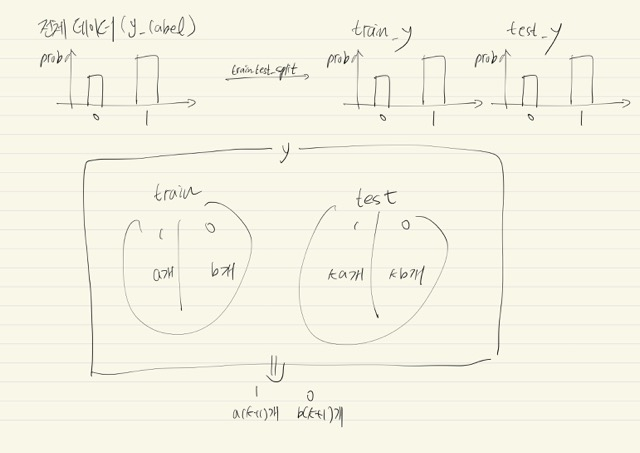)

In [119]:
# 분류문제임으로 y값의 범주에 따른 분포가 동일하도록 데이터 분할; stratify=raw_y

train_X,test_X,train_y,test_y = train_test_split(X_features,y_label, train_size=0.8,test_size=0.2, random_state=1, stratify=y_label)
print(train_X.shape,test_X.shape, train_y.shape,test_y.shape)

(1056, 9) (265, 9) (1056,) (265,)


In [120]:
a = train_y.value_counts()[1]
b = train_y.value_counts()[0]
ka = test_y.value_counts()[1]
kb = test_y.value_counts()[0]

In [121]:
ka/a

0.25

In [122]:
kb/b

0.2509765625

## 분류 평가함수

* 종류 : Accuracy, Precision, Recall, Specificity, f1-score, ROC AOU
* 참고 : https://hong-yp-ml-records.tistory.com/29

하나의 분류 모델 마다 사용하는 목적식이나 손실함수는 다르다.
> * logistic-regression : binary-cross-entropy
> * svm : margin

따라서 각 모델의 학습파라미터를 얻는데에 사용되는 것이 '목적식이나 손실함수'이고 이 모델을 다른 모델과 비교할 때는 '목적식이나 손실함수'가 다름으로, 공통적인 평가함수를 이용하여 모델 비교가 가능하다. 그리고 위에 있는 분류 평가함수가 그 종류이다.

In [123]:
# 분류(y값이 범주형변수)의 평가지표

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

## X 데이터 Standard Scale 진행

* 분류 문제임으로, y 데이터는 범주형이고 이 y데이터의 분포를 정규화해줄 필요는 없다.

In [124]:
scale=StandardScaler()
scale.fit(train_X) # train으로 fit을 적용하고
train_X=pd.DataFrame(scale.transform(train_X),columns=train_X.columns) # 이후에 train에 transform
test_X=pd.DataFrame(scale.transform(test_X),columns=test_X.columns) # test는 fit없이 transform만 적용한다.

## Logistic Regression

하이퍼 파라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가 
* Logistic Regression 하이퍼파라미터 후보 : C =0.01,0.1,1,10
* 평가지표 : Recall

In [125]:
# 이전에 사용한 cross_val_score 함수를 사용

from sklearn.model_selection import cross_val_score

In [126]:
# 로지스틱회귀의 하이퍼파라미터 튜닝
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 후보
C = [0.01,0.1,1,10]
lr_score = []

# 각 하이피파라미터당
for c in C:
    # 하이퍼파라미터를 고정한 모델을 선언하고
    lr_model=LogisticRegression(C=c)
    # 10-Fold 방법으로 학습데이터에 대해 평가(평균recall)를 진행하고 이 값을 저장
    lr_score.append(np.mean(cross_val_score(
        lr_model,train_X,train_y,scoring='recall',cv=10)))

idx1 = np.array(lr_score).argsort()[::-1][0] # 가장 큰 것의 index

print(lr_score)
print('-'*50)
print('Logistic-Regression best alpha :', C[idx1])

[0.0, 0.0, 0.1, 0.16666666666666666]
--------------------------------------------------
Logistic-Regression best alpha : 10


In [127]:
lr_score

[0.0, 0.0, 0.1, 0.16666666666666666]

## SVM

하이퍼 파라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가

* GridSearchCV cv=5를 통해 탐색
* SVM 하이퍼파라미터 후보
> * kernel = rbf, linear, poly
> * C = 0.5, 1.5, 10
* 평가지표 : Recall

In [128]:
# hyper-parameter의 종류가 2개(kernel, C)임으로, 이전에 사용한 cross_val_score를 이용하면
# 2개의 반복문을 사용해야한다.
# 따라서 보다 사용하기 쉬운 'GridSearchCV()'를 사용하자.
from sklearn.model_selection import GridSearchCV

# 객체 선언
from sklearn.svm import SVC # SVC = SVM + Classification vs SVR = SVM + Regression
model_svm = SVC()

# pca후의 train 데이터에 대해서 학습진행
model_svm.fit(train_X, train_y)

# HyperParameter 후보군
parameters={'kernel':['rbf','linear','poly'],
            'C':[0.5,1.5,10],
            'random_state':[1]}

# HyperParameter를 Tuning
model_svm=GridSearchCV(estimator=model_svm, param_grid=parameters,
                       scoring='recall', cv=10, refit=True)

# 객체는 이전에 'refit=True'에 의해 생성되었기에, 바로 train 데이터에 대한 학습을 진행하면 된다.
model_svm.fit(train_X,train_y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.5, 1.5, 10],
                         'kernel': ['rbf', 'linear', 'poly'],
                         'random_state': [1]},
             scoring='recall')

In [129]:
model_svm.best_params_

{'C': 10, 'kernel': 'rbf', 'random_state': 1}

## 분류 모델끼리 비교

학습데이터로 평가했을 때 가장 좋은 성능을 보인 하이퍼 파라미터값을 기준으로 Logistic Regression, SVM모델 만들어 테스트 데이터로 평가
* 평가지표 Recall, Precision, F1-score

In [130]:
# Logistic-Regression; C=10

lr_model=LogisticRegression(C=10)
lr_model.fit(train_X,train_y)

# SVM; C=10, kernel=rbf
model_svm = SVC(C=10, kernel='rbf')
model_svm.fit(train_X,train_y)

# 평가지표 또한, (정답,예측값) 순으로 넣어주어야한다.

# Logistic-Regression
print("recall :", recall_score(test_y,lr_model.predict(test_X)))
print("precision :", precision_score(test_y,lr_model.predict(test_X)))
print("f1_score :", f1_score(test_y,lr_model.predict(test_X)))
print('-'*50)

# SVM
print("recall :", recall_score(test_y,model_svm.predict(test_X)))
print("precision :", precision_score(test_y,model_svm.predict(test_X)))
print("f1_score :", f1_score(test_y,model_svm.predict(test_X)))

recall : 0.5
precision : 0.6666666666666666
f1_score : 0.5714285714285715
--------------------------------------------------
recall : 0.625
precision : 0.8333333333333334
f1_score : 0.7142857142857143


## 변수중요도; SVM

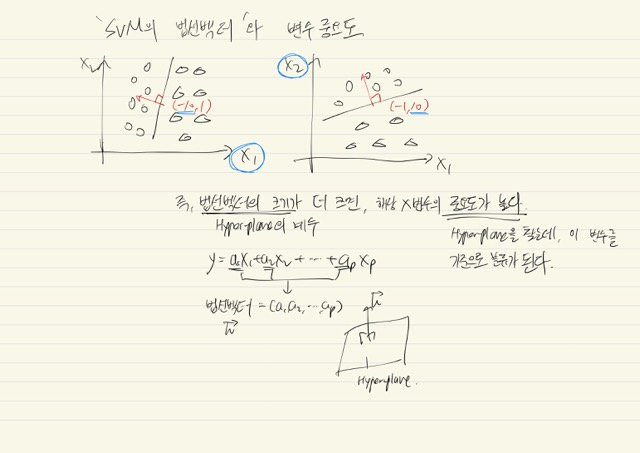

In [131]:
# model_svm.coef_

In [132]:
# SVM; C=10, kernel=rbf
model_svm = SVC(C=10, kernel='linear')
model_svm.fit(train_X,train_y)

model_svm.coef_

array([[ 2.06945722e-04,  1.50665199e-04,  3.68931722e-05,
         4.04350042e-04,  8.78720149e-05,  3.84863838e-05,
         1.76938586e-04, -4.82010014e-05, -6.55866575e-04]])

# 이론 문제

(직접 종이나 아이패드에 써서 코랩에 이미지 파일로 업로드 해주시면 됩니다)

**1.SVM의 수리적 모델링에서, 목적함수를 적고 증명과정을 서술하시오**

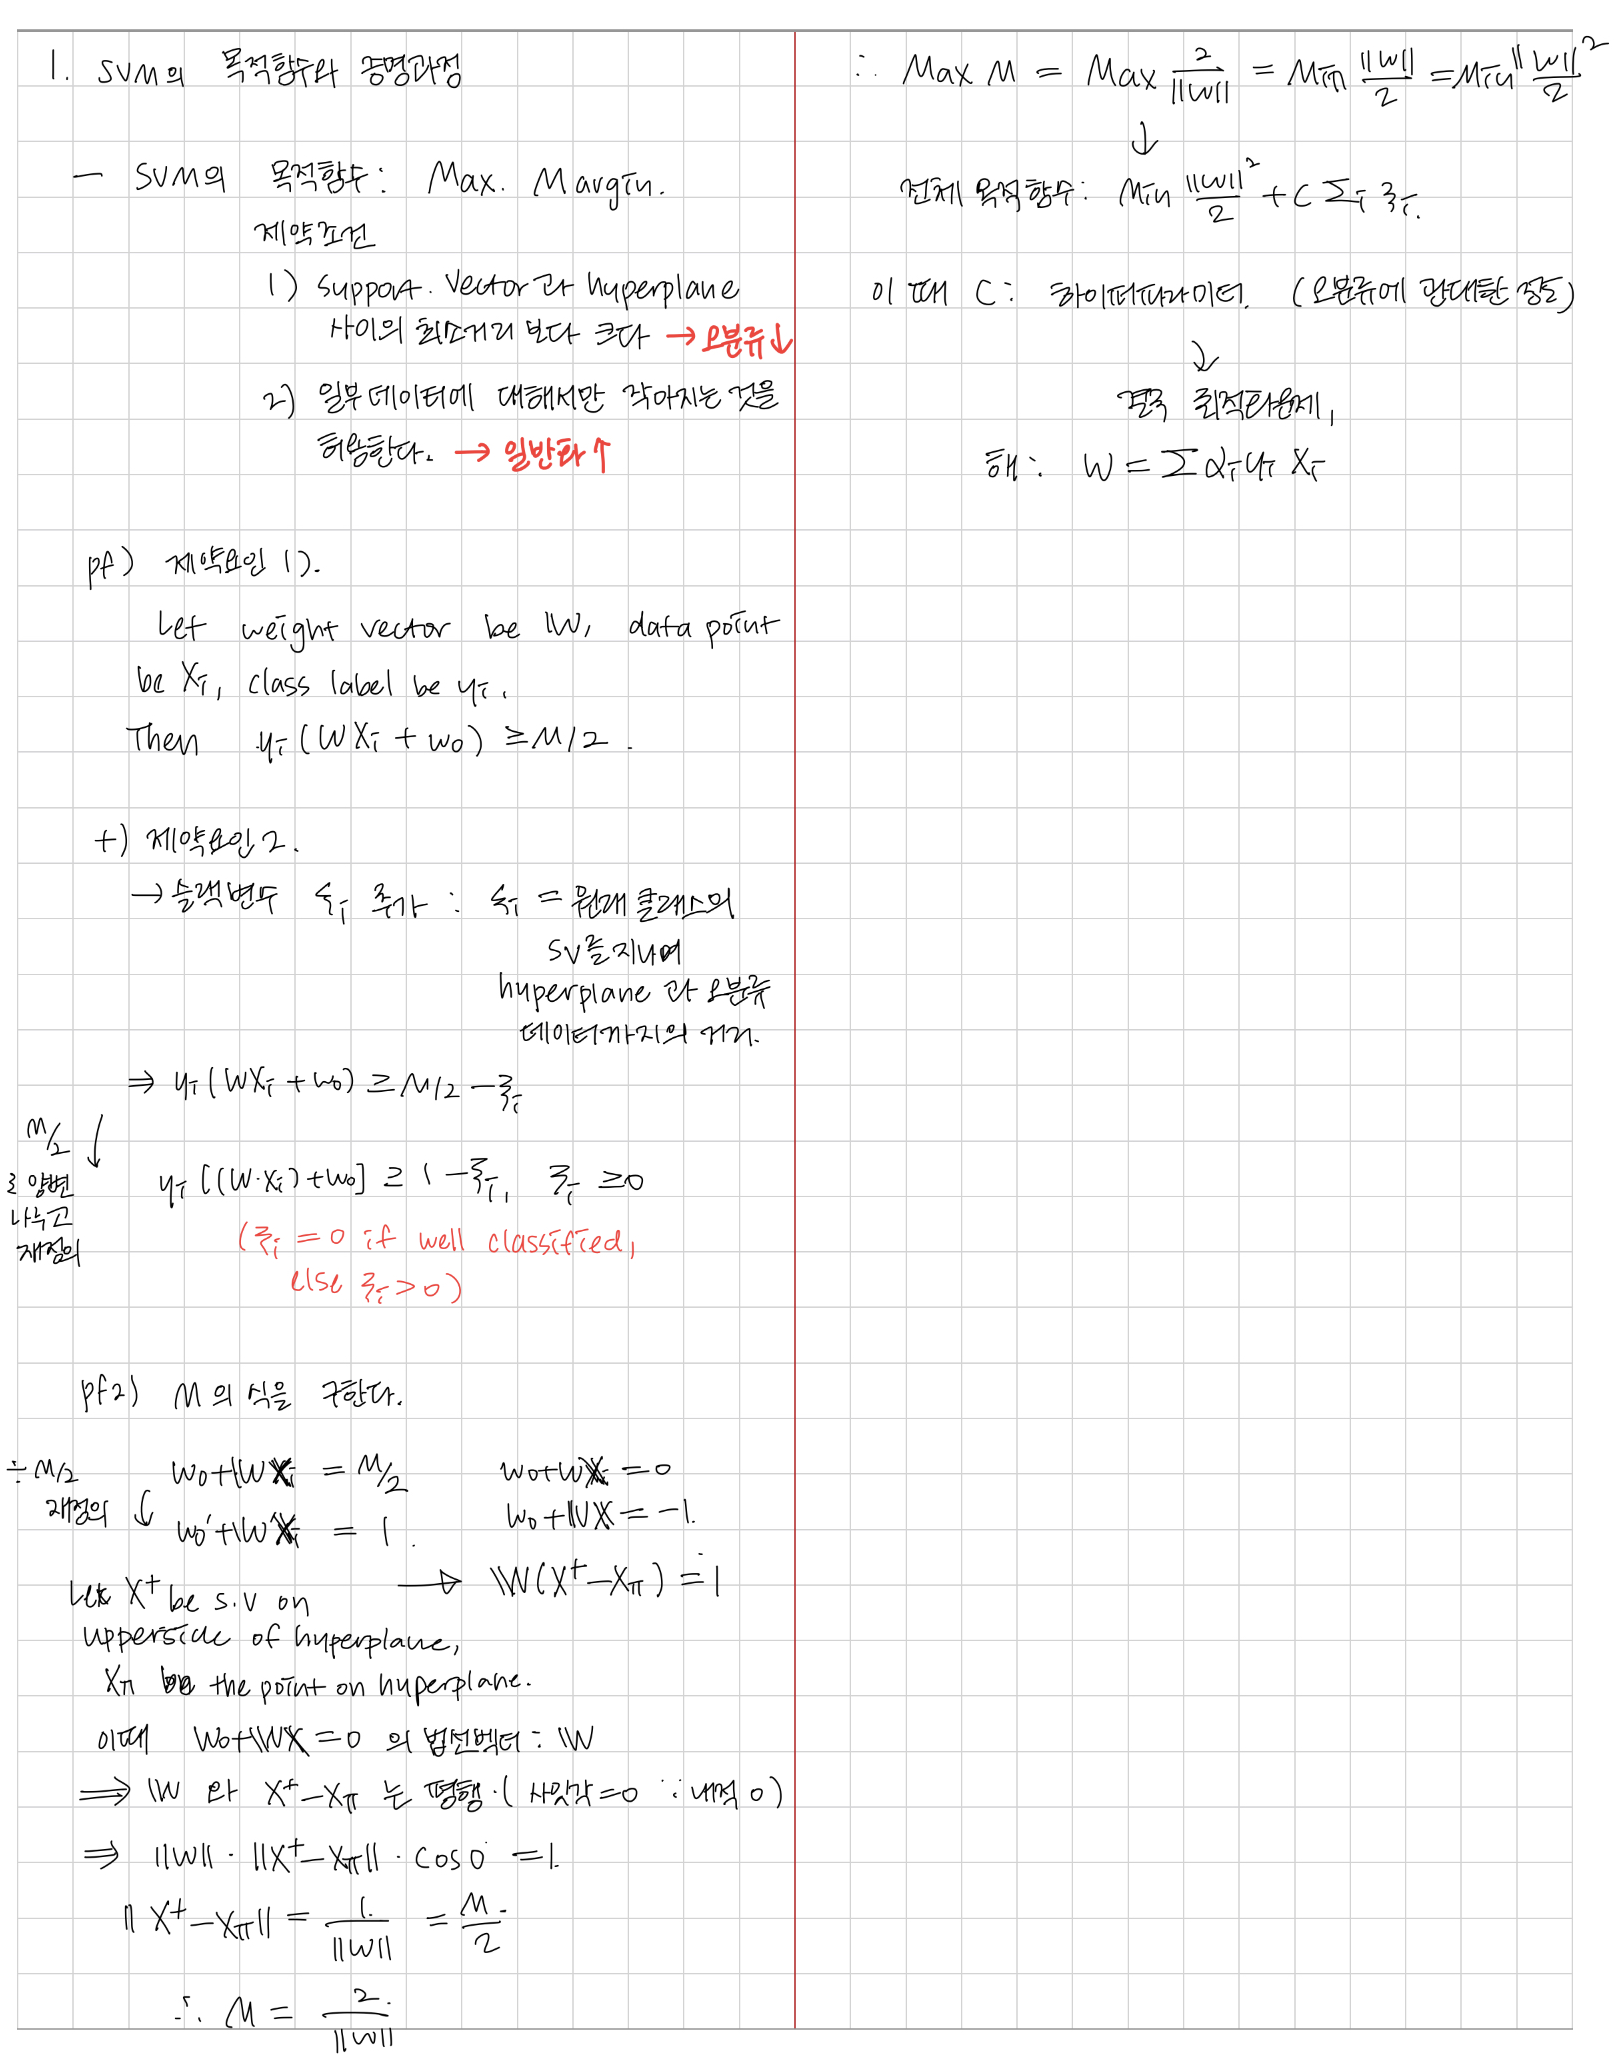

**2. 시그모이드 함수의 공식, 정의역, 치역을 작성하시오**

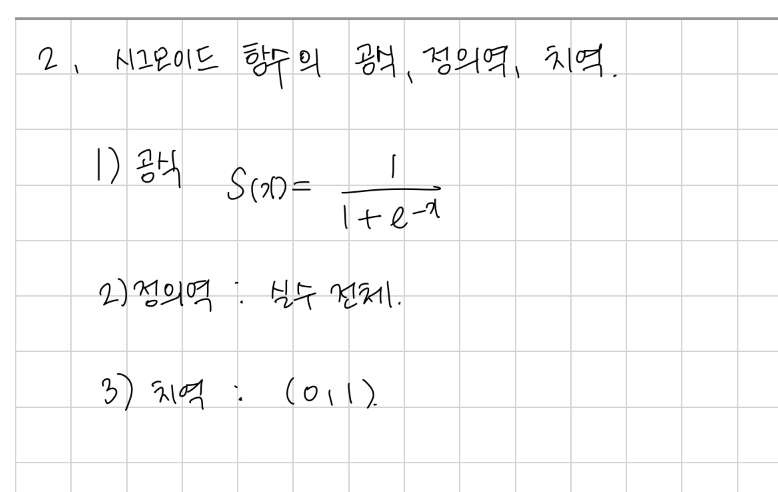

**3. 코드 실습 영상을 참고하여, 아래 그림과 같은 데이터의 F1-score를 계산하시오**


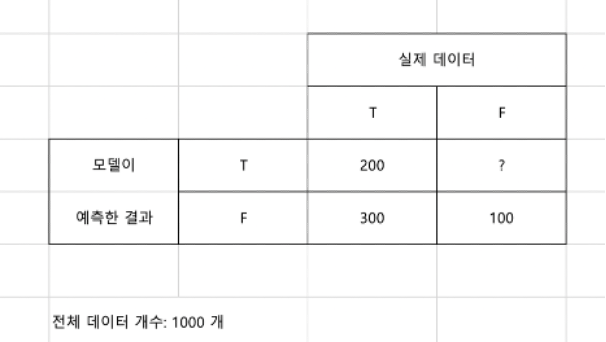

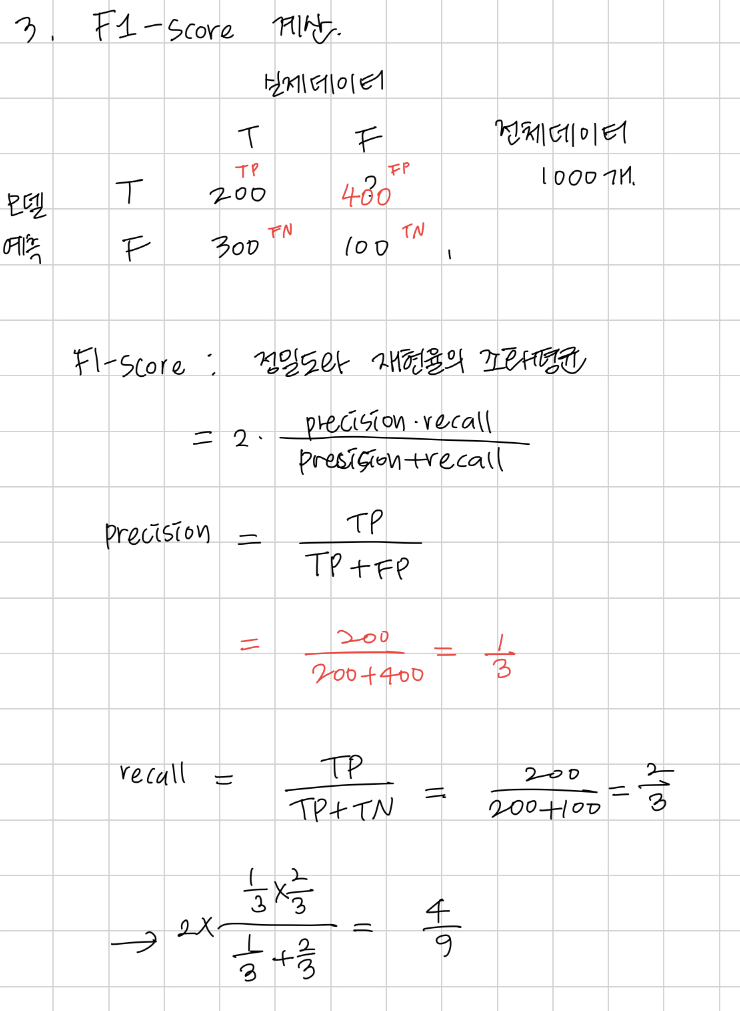

# 더 공부하고 싶으신 분들을 위한 자료
세션에서 다룬 내용을 하나하나 직접 구현해보실 수 있습니다.

**Chapter 3 – Classification**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

**Chapter 4 – Training Models**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

**Chapter 5 – Support Vector Machines**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>